# 🌍 **Tourism Analytics - Complete Implementation**

**Comprehensive ML Project for Tourism Data Analysis**

This notebook implements:
1. Data Cleaning
2. Preprocessing & Feature Engineering
3. Exploratory Data Analysis (EDA)
4. Model Training (Regression, Classification, Recommendation)
5. Model Evaluation
6. Deployment Preparation

---
### **Contribution - AKSHAY SOM**

## **Setup & Installation**

In [1]:
# Install required packages
!pip install -q openpyxl xgboost lightgbm plotly

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, f1_score
)

# XGBoost and LightGBM
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("-> All packages installed and imported successfully!")

-> All packages installed and imported successfully!


## **Data Upload**

**Instructions:**
1. Click the folder icon 📁 on the left sidebar
2. Upload all 9 Excel files:
   - Transaction.xlsx
   - User.xlsx
   - City.xlsx
   - Item.xlsx
   - Mode.xlsx
   - Type.xlsx
   - Continent.xlsx
   - Country.xlsx
   - Region.xlsx
3. Run the cell below

In [3]:
# Load all datasets
print("Loading datasets...\n")

try:
    transaction = pd.read_excel('Transaction.xlsx')
    user = pd.read_excel('User.xlsx')
    city = pd.read_excel('City.xlsx')
    item = pd.read_excel('Item.xlsx')
    mode = pd.read_excel('Mode.xlsx')
    type_data = pd.read_excel('Type.xlsx')
    continent = pd.read_excel('Continent.xlsx')
    country = pd.read_excel('Country.xlsx')
    region = pd.read_excel('Region.xlsx')

    print("-> All datasets loaded successfully!\n")

    # Display dataset info
    datasets = {
        'Transaction': transaction,
        'User': user,
        'City': city,
        'Item': item,
        'Mode': mode,
        'Type': type_data,
        'Continent': continent,
        'Country': country,
        'Region': region
    }

    for name, df in datasets.items():
        print(f"{name:15s}: {df.shape[0]:,} rows × {df.shape[1]} columns")

except FileNotFoundError as e:
    print(" Error: Please upload all Excel files first!")
    print(f"Missing file: {e}")

Loading datasets...

-> All datasets loaded successfully!

Transaction    : 52,930 rows × 7 columns
User           : 33,530 rows × 5 columns
City           : 9,143 rows × 3 columns
Item           : 30 rows × 5 columns
Mode           : 6 rows × 2 columns
Type           : 17 rows × 2 columns
Continent      : 6 rows × 2 columns
Country        : 165 rows × 3 columns
Region         : 22 rows × 3 columns


---
# 1️⃣ **DATA CLEANING**

## Requirements:
- Handle missing values in transaction, user, and city datasets
- Resolve discrepancies in city names and categorical variables
- Standardize date and time format
- Handle outliers and incorrect entries in ratings

### **1.1 Handle Missing Values**

In [4]:
print("="*80)
print("1. HANDLING MISSING VALUES")
print("="*80 + "\n")

# Check missing values in all datasets
for name, df in datasets.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"{name} - Missing Values:")
        print(missing[missing > 0])
        print()

# Transaction Dataset - Drop rows with missing critical values
if transaction.isnull().sum().sum() > 0:
    transaction = transaction.dropna(subset=['TransactionId', 'UserId', 'AttractionId', 'Rating'])
    print("Transaction: Dropped rows with missing critical values")

# User Dataset - Handle missing CityId
missing_city = user['CityId'].isnull().sum()
if missing_city > 0:
    print(f"User: {missing_city} missing CityId values → Filled with 0 (Unknown)")
    user['CityId'] = user['CityId'].fillna(0).astype(int)

# City Dataset - Handle missing CityName
missing_name = city['CityName'].isnull().sum()
if missing_name > 0:
    print(f"City: {missing_name} missing CityName values → Filled with 'Unknown'")
    city['CityName'] = city['CityName'].fillna('Unknown')

print("\n-> Missing values handled successfully")

1. HANDLING MISSING VALUES

User - Missing Values:
CityId    4
dtype: int64

City - Missing Values:
CityName    1
dtype: int64

User: 4 missing CityId values → Filled with 0 (Unknown)
City: 1 missing CityName values → Filled with 'Unknown'

-> Missing values handled successfully


### **1.2 Resolve Categorical Discrepancies**

In [5]:
print("="*80)
print("2. RESOLVING CATEGORICAL DISCREPANCIES")
print("="*80 + "\n")

# Remove placeholder records ('-' or similar)
mode = mode[mode['VisitMode'] != '-'].copy()
print("Mode: Removed placeholder records ('-')")

continent = continent[continent['Continent'] != '-'].copy()
print("Continent: Removed placeholder records ('-')")

region = region[region['Region'] != '-'].copy()
print("Region: Removed placeholder records ('-')")

country = country[country['Country'] != '-'].copy()
print("Country: Removed placeholder records ('-')")

city = city[city['CityName'] != '-'].copy()
print("City: Removed placeholder records ('-')")

# Standardize city names: title case, strip whitespace
city['CityName'] = city['CityName'].str.strip().str.title()
print(f"City: Standardized {len(city)} city names to title case")

print("\n-> Categorical discrepancies resolved")

2. RESOLVING CATEGORICAL DISCREPANCIES

Mode: Removed placeholder records ('-')
Continent: Removed placeholder records ('-')
Region: Removed placeholder records ('-')
Country: Removed placeholder records ('-')
City: Removed placeholder records ('-')
City: Standardized 9135 city names to title case

-> Categorical discrepancies resolved


### **1.3 Standardize Date and Time Format**

In [6]:
print("="*80)
print("3. STANDARDIZING DATE AND TIME FORMATS")
print("="*80 + "\n")

# Ensure VisitYear and VisitMonth are integers
transaction['VisitYear'] = transaction['VisitYear'].astype(int)
transaction['VisitMonth'] = transaction['VisitMonth'].astype(int)

# Validate month range (1-12)
invalid_months = transaction[(transaction['VisitMonth'] < 1) | (transaction['VisitMonth'] > 12)]
if len(invalid_months) > 0:
    print(f"Found {len(invalid_months)} records with invalid months → Removed")
    transaction = transaction[(transaction['VisitMonth'] >= 1) & (transaction['VisitMonth'] <= 12)]

# Create standardized date field (first day of month)
transaction['VisitDate'] = pd.to_datetime(
    transaction['VisitYear'].astype(str) + '-' +
    transaction['VisitMonth'].astype(str) + '-01'
)

# Validate year range
current_year = datetime.now().year
invalid_years = transaction[(transaction['VisitYear'] < 2000) | (transaction['VisitYear'] > current_year)]
if len(invalid_years) > 0:
    print(f"Found {len(invalid_years)} records with invalid years → Removed")
    transaction = transaction[(transaction['VisitYear'] >= 2000) & (transaction['VisitYear'] <= current_year)]

print(f"Date Range: {transaction['VisitYear'].min()} - {transaction['VisitYear'].max()}")
print("Created standardized VisitDate field")

print("\n-> Date and time formats standardized")

3. STANDARDIZING DATE AND TIME FORMATS

Date Range: 2013 - 2022
Created standardized VisitDate field

-> Date and time formats standardized


### **1.4 Handle Outliers and Incorrect Entries**

In [7]:
print("="*80)
print("4. HANDLING OUTLIERS AND INCORRECT ENTRIES")
print("="*80 + "\n")

original_count = len(transaction)

# Rating validation (should be 1-5)
print("Rating Analysis:")
print(f"  Original range: {transaction['Rating'].min()} - {transaction['Rating'].max()}")

invalid_ratings = transaction[(transaction['Rating'] < 1) | (transaction['Rating'] > 5)]
if len(invalid_ratings) > 0:
    print(f"  Found {len(invalid_ratings)} invalid ratings → Removed")
    transaction = transaction[(transaction['Rating'] >= 1) & (transaction['Rating'] <= 5)]

print(f"  Final range: {transaction['Rating'].min()} - {transaction['Rating'].max()}")
print(f"  Mean: {transaction['Rating'].mean():.2f}")
print(f"  Median: {transaction['Rating'].median():.1f}\n")

# Check for duplicates
duplicates = transaction.duplicated(subset=['TransactionId'])
if duplicates.sum() > 0:
    print(f"Found {duplicates.sum()} duplicate TransactionIds → Removed")
    transaction = transaction.drop_duplicates(subset=['TransactionId'])

# Validate VisitMode references
valid_modes = mode['VisitModeId'].unique()
invalid_modes = transaction[~transaction['VisitMode'].isin(valid_modes)]
if len(invalid_modes) > 0:
    print(f"Found {len(invalid_modes)} records with invalid VisitMode → Removed")
    transaction = transaction[transaction['VisitMode'].isin(valid_modes)]

# Validate AttractionId references
valid_attractions = item['AttractionId'].unique()
invalid_attractions = transaction[~transaction['AttractionId'].isin(valid_attractions)]
if len(invalid_attractions) > 0:
    print(f"Found {len(invalid_attractions)} records with invalid AttractionId → Removed")
    transaction = transaction[transaction['AttractionId'].isin(valid_attractions)]

# Validate UserId references
valid_users = user['UserId'].unique()
invalid_users = transaction[~transaction['UserId'].isin(valid_users)]
if len(invalid_users) > 0:
    print(f"Found {len(invalid_users)} records with invalid UserId → Removed")
    transaction = transaction[transaction['UserId'].isin(valid_users)]

cleaned_count = len(transaction)
total_removed = original_count - cleaned_count

print(f"\n-> Data cleaning completed")
print(f"  Original records: {original_count:,}")
print(f"  Cleaned records: {cleaned_count:,}")
print(f"  Removed records: {total_removed:,} ({total_removed/original_count*100:.2f}%)")

4. HANDLING OUTLIERS AND INCORRECT ENTRIES

Rating Analysis:
  Original range: 1 - 5
  Final range: 1 - 5
  Mean: 4.16
  Median: 4.0


-> Data cleaning completed
  Original records: 52,930
  Cleaned records: 52,930
  Removed records: 0 (0.00%)


---
# 2️⃣ **PREPROCESSING**

## Requirements:
- Feature Engineering: Encode categorical variables
- Aggregate user-level features
- Join datasets to create consolidated dataset
- Normalization: Scale numerical features

### **2.1 Join Datasets (Create Consolidated Dataset)**

In [8]:
print("="*80)
print("1. JOINING DATASETS - Creating Consolidated Dataset")
print("="*80 + "\n")

# Start with transaction data
df = transaction.copy()
print(f"Starting with Transaction data: {len(df):,} records\n")

# Join User demographics
df = df.merge(user, on='UserId', how='left')
print(f"-> Added user demographics")

# ── Join Visit Mode ──────────────────────────────────────────────────────────
# The mode table has two columns: VisitModeId (integer key) and VisitMode (string label)
# To avoid pandas auto-suffixing (which creates confusing names like VisitMode_mode or
# VisitMode_y), we rename the string column to 'VisitModeName' BEFORE merging.
mode_clean = mode.rename(columns={'VisitMode': 'VisitModeName'})
# mode_clean now has: VisitModeId | VisitModeName
df = df.merge(mode_clean, left_on='VisitMode', right_on='VisitModeId', how='left')
# Result: df['VisitMode']     = integer ID   (1,2,3,4,5)    from transaction
#         df['VisitModeName']  = string label ('Business',…)  from mode table
print(f"-> Added VisitModeName | values: {sorted(df['VisitModeName'].dropna().unique().tolist())}")

# Join Attraction information
df = df.merge(
    item[['AttractionId', 'AttractionCityId', 'AttractionTypeId', 'Attraction']],
    on='AttractionId', how='left'
)
print(f"-> Added attraction details")

# Join Attraction Type
df = df.merge(type_data, on='AttractionTypeId', how='left')
print(f"-> Added attraction type")

# Join User City
user_city = city[['CityId', 'CityName', 'CountryId']].copy()
user_city.columns = ['CityId', 'UserCityName', 'UserCountryId']
df = df.merge(user_city, on='CityId', how='left')
print(f"-> Added user city")

# Join User Country
user_country = country[['CountryId', 'Country', 'RegionId']].copy()
user_country.columns = ['UserCountryId', 'UserCountry', 'UserRegionId']
df = df.merge(user_country, on='UserCountryId', how='left')
print(f"-> Added user country")

# Join User Region
user_region = region[['RegionId', 'Region', 'ContinentId']].copy()
user_region.columns = ['UserRegionId', 'UserRegion', 'UserContinentId']
df = df.merge(user_region, on='UserRegionId', how='left')
print(f"-> Added user region")

# Join User Continent
user_continent = continent[['ContinentId', 'Continent']].copy()
user_continent.columns = ['UserContinentId', 'UserContinent']
df = df.merge(user_continent, on='UserContinentId', how='left')
print(f"-> Added user continent")

# Join Attraction City
attr_city = city[['CityId', 'CityName']].copy()
attr_city.columns = ['AttractionCityId', 'AttractionCityName']
df = df.merge(attr_city, on='AttractionCityId', how='left')
print(f"-> Added attraction city")

print(f"\n-> Dataset consolidation completed: {df.shape[0]:,} rows × {df.shape[1]} columns")

# ── Sanity check ─────────────────────────────────────────────────────────────
assert 'VisitModeName' in df.columns, "ERROR: VisitModeName column missing!"
print(f"\nColumn sanity check passed")
print(f"  VisitMode     (int ID) : {sorted(df['VisitMode'].unique().tolist())}")
print(f"  VisitModeName (label)  : {sorted(df['VisitModeName'].dropna().unique().tolist())}")


1. JOINING DATASETS - Creating Consolidated Dataset

Starting with Transaction data: 52,930 records

-> Added user demographics
-> Added VisitModeName | values: ['Business', 'Couples', 'Family', 'Friends', 'Solo']
-> Added attraction details
-> Added attraction type
-> Added user city
-> Added user country
-> Added user region
-> Added user continent
-> Added attraction city

-> Dataset consolidation completed: 52,930 rows × 26 columns

Column sanity check passed
  VisitMode     (int ID) : [1, 2, 3, 4, 5]
  VisitModeName (label)  : ['Business', 'Couples', 'Family', 'Friends', 'Solo']


### **2.2 Feature Engineering - Aggregate User-Level Features**

In [9]:
print("="*80)
print("2. AGGREGATING USER-LEVEL FEATURES")
print("="*80 + "\n")

# ── User overall statistics ───────────────────────────────────────────────────
user_stats = df.groupby('UserId').agg(
    user_avg_rating         = ('Rating',        'mean'),
    user_rating_std         = ('Rating',        'std'),
    user_min_rating         = ('Rating',        'min'),
    user_max_rating         = ('Rating',        'max'),
    user_rating_count       = ('Rating',        'count'),
    user_visit_count        = ('TransactionId', 'count'),
    user_unique_attractions = ('AttractionId',  'nunique'),
    user_first_visit_year   = ('VisitYear',     'min'),
    user_last_visit_year    = ('VisitYear',     'max')
).reset_index()
user_stats['user_rating_std'] = user_stats['user_rating_std'].fillna(0)
print(f"-> Created {len(user_stats.columns) - 1} user overall features")

# ── User statistics per VisitModeName ────────────────────────────────────────
# VisitModeName = 'Business' | 'Couples' | 'Family' | 'Friends' | 'Solo'
user_by_mode = (
    df.dropna(subset=['VisitModeName'])
      .groupby(['UserId', 'VisitModeName'])
      .agg(
          mode_avg_rating  = ('Rating', 'mean'),
          mode_visit_count = ('Rating', 'count')
      )
      .reset_index()
)

# Most-preferred visit mode per user (mode with highest visit count)
most_frequent_mode = (
    user_by_mode
    .sort_values('mode_visit_count', ascending=False)
    .groupby('UserId')
    .first()
    .reset_index()
    [['UserId', 'VisitModeName']]
    .rename(columns={'VisitModeName': 'user_preferred_mode'})
)
print(f"-> Identified preferred visit mode for {len(most_frequent_mode):,} users")

# ── Attraction-level statistics ───────────────────────────────────────────────
attraction_stats = df.groupby('AttractionId').agg(
    attraction_avg_rating   = ('Rating', 'mean'),
    attraction_rating_std   = ('Rating', 'std'),
    attraction_visit_count  = ('Rating', 'count'),
    attraction_unique_users = ('UserId', 'nunique')
).reset_index()
attraction_stats['attraction_rating_std'] = attraction_stats['attraction_rating_std'].fillna(0)
print(f"-> Created {len(attraction_stats.columns) - 1} attraction features")

# ── Merge all aggregated features back into main df ───────────────────────────
df = df.merge(user_stats,         on='UserId',       how='left')
df = df.merge(most_frequent_mode, on='UserId',       how='left')
df = df.merge(attraction_stats,   on='AttractionId', how='left')

print(f"\n-> Feature aggregation completed: {df.shape[1]} total columns")

2. AGGREGATING USER-LEVEL FEATURES

-> Created 9 user overall features
-> Identified preferred visit mode for 33,530 users
-> Created 4 attraction features

-> Feature aggregation completed: 40 total columns


### **2.3 Feature Engineering - Create Additional Features**

In [10]:
print("="*80)
print("3. CREATING ADDITIONAL ENGINEERED FEATURES")
print("="*80 + "\n")

# Temporal features
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['VisitMonth'].apply(get_season)
df['Quarter'] = df['VisitMonth'].apply(lambda x: (x-1)//3 + 1)
df['IsHolidaySeason'] = df['VisitMonth'].isin([6, 7, 8, 12])
print("-> Created 3 temporal features")

# User engagement features
df['user_visit_frequency'] = df['user_visit_count'] / (df['user_last_visit_year'] - df['user_first_visit_year'] + 1)
df['user_visit_frequency'] = df['user_visit_frequency'].fillna(df['user_visit_count'])
df['user_attraction_diversity'] = df['user_unique_attractions'] / df['user_visit_count']
print("-> Created 2 user engagement features")

# Rating deviation features
df['rating_vs_user_avg'] = df['Rating'] - df['user_avg_rating']
df['rating_vs_attraction_avg'] = df['Rating'] - df['attraction_avg_rating']
print("-> Created 2 rating deviation features")

# Popularity features
df['attraction_popularity_score'] = df['attraction_visit_count'] / df['attraction_visit_count'].max()
df['user_activity_score'] = df['user_visit_count'] / df['user_visit_count'].max()
print("-> Created 2 popularity features")

print(f"\n-> Additional feature engineering completed: {df.shape[1]} total columns")

3. CREATING ADDITIONAL ENGINEERED FEATURES

-> Created 3 temporal features
-> Created 2 user engagement features
-> Created 2 rating deviation features
-> Created 2 popularity features

-> Additional feature engineering completed: 49 total columns


### **2.4 Encode Categorical Variables**

In [11]:
print("="*80)
print("4. ENCODING CATEGORICAL VARIABLES")
print("="*80 + "\n")

# Store encoders
encoders = {}

# Categorical columns to encode
# Note: 'VisitModeName' is the human-readable visit mode (Business, Couples, Family, Friends, Solo)
categorical_columns = [
    'VisitModeName',  # Renamed from VisitMode_y for clarity
    'UserContinent',
    'UserRegion',
    'UserCountry',
    'AttractionType',
    'Season',
    'user_preferred_mode'
]

for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = df[col].fillna('Unknown')
        df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
        print(f"-> Encoded {col} ({len(le.classes_)} unique values)")

print(f"\n-> Categorical encoding completed: {len(categorical_columns)} variables encoded")

4. ENCODING CATEGORICAL VARIABLES

-> Encoded VisitModeName (5 unique values)
-> Encoded UserContinent (6 unique values)
-> Encoded UserRegion (22 unique values)
-> Encoded UserCountry (152 unique values)
-> Encoded AttractionType (17 unique values)
-> Encoded Season (4 unique values)
-> Encoded user_preferred_mode (5 unique values)

-> Categorical encoding completed: 7 variables encoded


### **2.5 Normalize Numerical Features**

In [12]:
print("="*80)
print("5. NORMALIZING NUMERICAL FEATURES")
print("="*80 + "\n")

# Numerical features to normalize
numerical_features = [
    'Rating',
    'user_avg_rating',
    'user_rating_std',
    'user_visit_count',
    'attraction_avg_rating',
    'attraction_rating_std',
    'attraction_visit_count',
    'user_visit_frequency',
    'user_attraction_diversity',
    'attraction_popularity_score',
    'user_activity_score'
]

# Filter to existing columns
numerical_features = [col for col in numerical_features if col in df.columns]

# StandardScaler (z-score normalization)
scaler_standard = StandardScaler()
df_scaled_standard = pd.DataFrame(
    scaler_standard.fit_transform(df[numerical_features]),
    columns=[f'{col}_scaled' for col in numerical_features],
    index=df.index
)
df = pd.concat([df, df_scaled_standard], axis=1)
print(f"-> Applied StandardScaler to {len(numerical_features)} features")

# MinMaxScaler (0-1 normalization)
scaler_minmax = MinMaxScaler()
df_scaled_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(df[numerical_features]),
    columns=[f'{col}_normalized' for col in numerical_features],
    index=df.index
)
df = pd.concat([df, df_scaled_minmax], axis=1)
print(f"-> Applied MinMaxScaler to {len(numerical_features)} features")

print(f"\n-> Normalization completed: {df.shape[1]} total columns")
print(f"\nFinal preprocessed dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")

5. NORMALIZING NUMERICAL FEATURES

-> Applied StandardScaler to 11 features
-> Applied MinMaxScaler to 11 features

-> Normalization completed: 78 total columns

Final preprocessed dataset: 52,930 rows × 78 columns


In [13]:
# Display sample of preprocessed data
print("\nSample of preprocessed data:")
df.head()


Sample of preprocessed data:


,TransactionId,UserId,VisitYear,VisitMonth,VisitMode,AttractionId,Rating,VisitDate,ContinentId,RegionId,...,user_avg_rating_normalized,user_rating_std_normalized,user_visit_count_normalized,attraction_avg_rating_normalized,attraction_rating_std_normalized,attraction_visit_count_normalized,user_visit_frequency_normalized,user_attraction_diversity_normalized,attraction_popularity_score_normalized,user_activity_score_normalized
0,3,70456,2022,10,2,640,5,2022-10-01,5,21,...,1.0,0.000000,0.000000,0.663674,0.361852,1.0,0.034483,1.00000,1.0,0.000000
1,8,7567,2022,10,4,640,5,2022-10-01,2,8,...,1.0,0.000000,0.000000,0.663674,0.361852,1.0,0.034483,1.00000,1.0,0.000000
2,9,79069,2022,10,3,640,5,2022-10-01,2,9,...,1.0,0.000000,0.000000,0.663674,0.361852,1.0,0.034483,1.00000,1.0,0.000000
3,10,31019,2022,10,3,640,3,2022-10-01,5,17,...,0.5,0.000000,0.017241,0.663674,0.361852,1.0,0.080460,0.47619,1.0,0.017241
4,15,43611,2022,10,2,640,3,2022-10-01,5,21,...,0.5,0.353553,0.034483,0.663674,0.361852,1.0,0.126437,1.00000,1.0,0.034483


---
# 3️⃣ **EXPLORATORY DATA ANALYSIS (EDA)**

## Requirements:
- Visualize user distribution across continents, countries, regions
- Explore attraction types and popularity based on ratings
- Investigate correlation between VisitMode and demographics
- Analyze rating distribution across attractions and regions

### **3.1 Summary Statistics**

In [14]:
print("="*80)
print("DATASET SUMMARY STATISTICS")
print("="*80 + "\n")

print(f"Total Records: {len(df):,}")
print(f"Unique Users: {df['UserId'].nunique():,}")
print(f"Unique Attractions: {df['AttractionId'].nunique()}")
print(f"Countries: {df['UserCountry'].nunique()}")
print(f"Date Range: {df['VisitYear'].min()} - {df['VisitYear'].max()}")
print(f"Average Rating: {df['Rating'].mean():.2f}/5.0")

print("\nTop 10 Most Visited Attractions:")
top_attractions = df['Attraction'].value_counts().head(10)
for i, (attr, count) in enumerate(top_attractions.items(), 1):
    print(f"{i:2d}. {attr:40s} - {count:,} visits")

print("\nVisit Mode Distribution:")
mode_dist = df['VisitModeName'].value_counts()
for mode, count in mode_dist.items():
    pct = count/len(df)*100
    print(f"{mode:15s} - {count:,} ({pct:.1f}%)")

DATASET SUMMARY STATISTICS

Total Records: 52,930
Unique Users: 33,530
Unique Attractions: 30
Countries: 152
Date Range: 2013 - 2022
Average Rating: 4.16/5.0

Top 10 Most Visited Attractions:
 1. Sacred Monkey Forest Sanctuary           - 13,198 visits
 2. Waterbom Bali                            - 6,429 visits
 3. Tegalalang Rice Terrace                  - 5,815 visits
 4. Uluwatu Temple                           - 3,359 visits
 5. Tanah Lot Temple                         - 3,352 visits
 6. Sanur Beach                              - 3,044 visits
 7. Seminyak Beach                           - 2,914 visits
 8. Kuta Beach - Bali                        - 2,765 visits
 9. Merapi Volcano                           - 2,235 visits
10. Tegenungan Waterfall                     - 2,190 visits

Visit Mode Distribution:
Couples         - 21,620 (40.8%)
Family          - 15,217 (28.7%)
Friends         - 10,945 (20.7%)
Solo            - 4,525 (8.5%)
Business        - 623 (1.2%)


### **3.2 User Distribution Across Continents, Countries, and Regions**

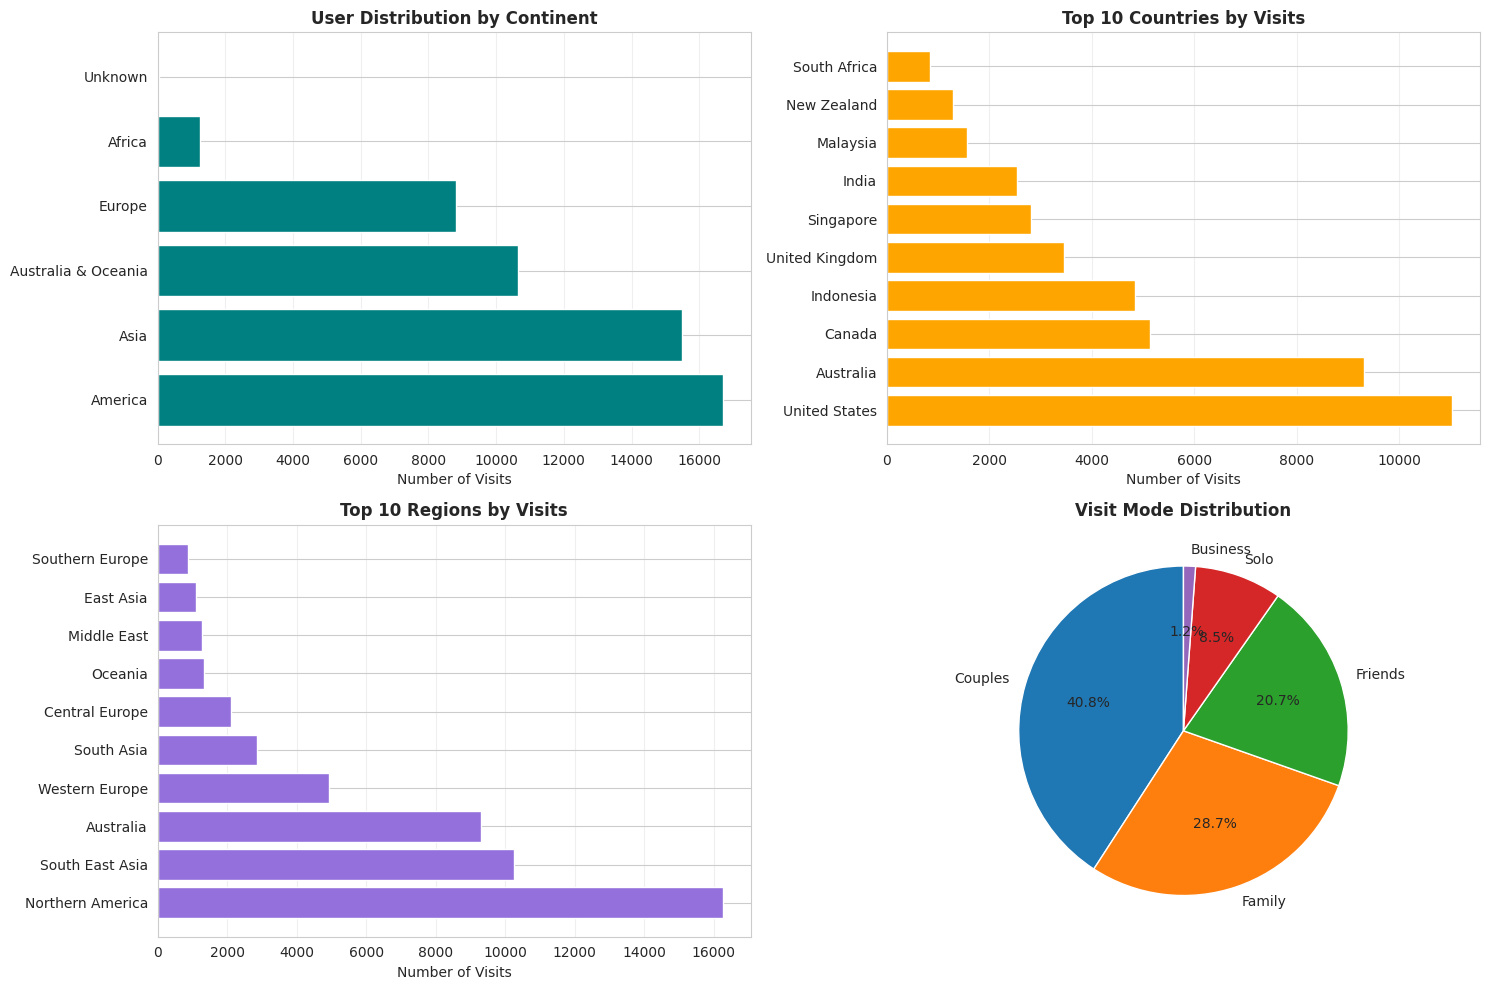

-> Saved: eda_geographic_distribution.png


In [15]:
# Geographic distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Continents
continent_dist = df['UserContinent'].value_counts()
axes[0, 0].barh(continent_dist.index, continent_dist.values, color='teal')
axes[0, 0].set_title('User Distribution by Continent', fontweight='bold')
axes[0, 0].set_xlabel('Number of Visits')
axes[0, 0].grid(axis='x', alpha=0.3)

# Top 10 Countries
country_dist = df['UserCountry'].value_counts().head(10)
axes[0, 1].barh(country_dist.index, country_dist.values, color='orange')
axes[0, 1].set_title('Top 10 Countries by Visits', fontweight='bold')
axes[0, 1].set_xlabel('Number of Visits')
axes[0, 1].grid(axis='x', alpha=0.3)

# Top 10 Regions
region_dist = df['UserRegion'].value_counts().head(10)
axes[1, 0].barh(region_dist.index, region_dist.values, color='mediumpurple')
axes[1, 0].set_title('Top 10 Regions by Visits', fontweight='bold')
axes[1, 0].set_xlabel('Number of Visits')
axes[1, 0].grid(axis='x', alpha=0.3)

# Visit modes
mode_dist = df['VisitModeName'].value_counts()
axes[1, 1].pie(mode_dist.values, labels=mode_dist.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Visit Mode Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig('eda_geographic_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("-> Saved: eda_geographic_distribution.png")

### **3.3 Attraction Types and Popularity**

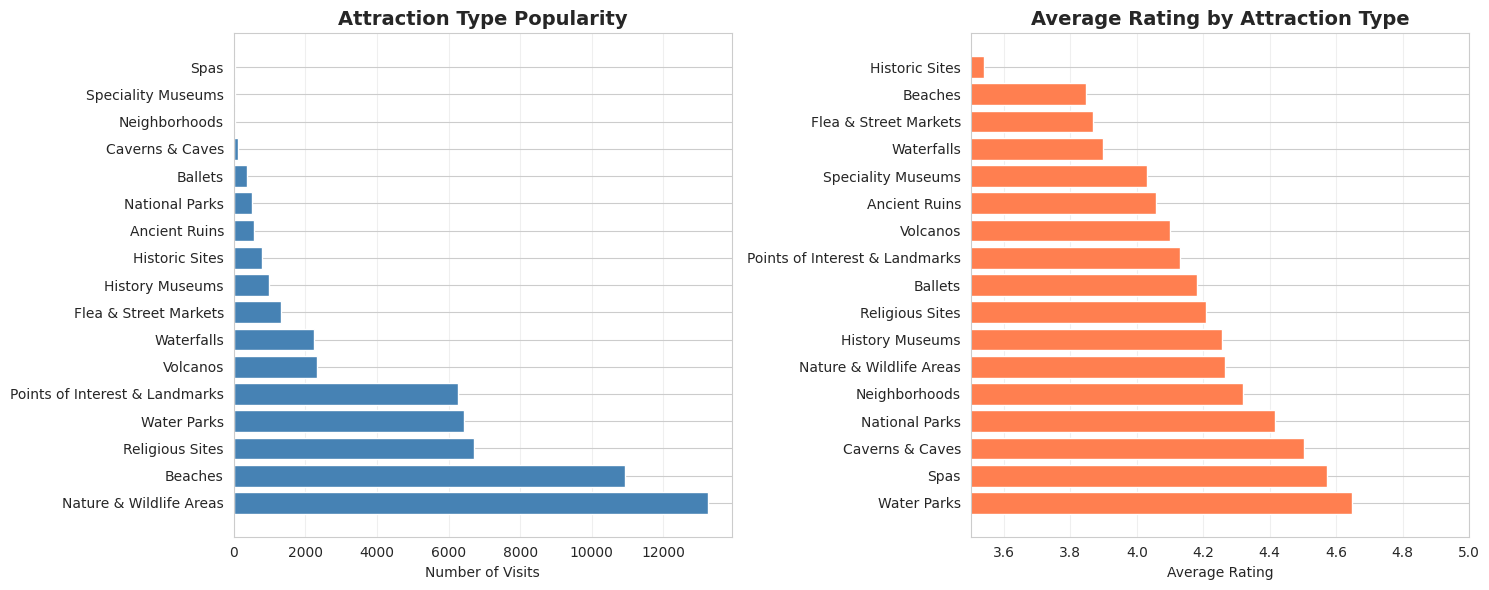

-> Saved: eda_attraction_types.png


In [16]:
# Attraction type analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Popularity by type
type_popularity = df.groupby('AttractionType').size().sort_values(ascending=False)
axes[0].barh(type_popularity.index, type_popularity.values, color='steelblue')
axes[0].set_title('Attraction Type Popularity', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Number of Visits')
axes[0].grid(axis='x', alpha=0.3)

# Rating by type
type_ratings = df.groupby('AttractionType')['Rating'].mean().sort_values(ascending=False)
axes[1].barh(type_ratings.index, type_ratings.values, color='coral')
axes[1].set_title('Average Rating by Attraction Type', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Average Rating')
axes[1].set_xlim([3.5, 5])
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('eda_attraction_types.png', dpi=300, bbox_inches='tight')
plt.show()

print("-> Saved: eda_attraction_types.png")

### **3.4 VisitMode vs Demographics Correlation**

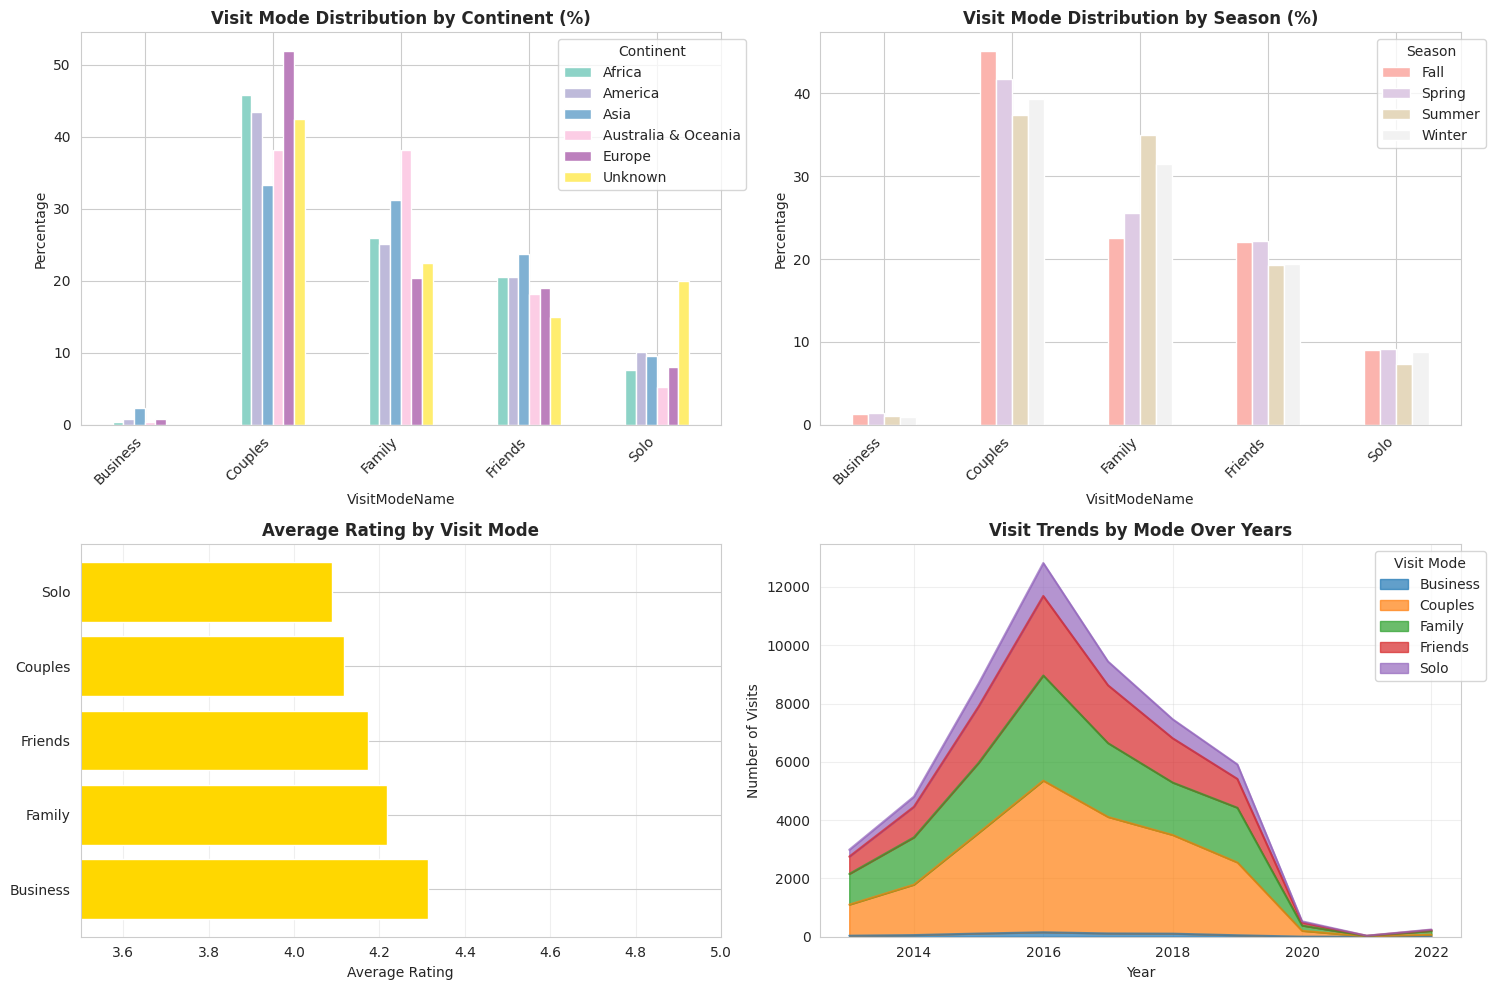

-> Saved: eda_visitmode_demographics.png


In [17]:
# VisitMode correlation analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Visit mode by continent
mode_continent = pd.crosstab(df['VisitModeName'], df['UserContinent'], normalize='columns') * 100
mode_continent.plot(kind='bar', ax=axes[0, 0], colormap='Set3')
axes[0, 0].set_title('Visit Mode Distribution by Continent (%)', fontweight='bold')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].legend(title='Continent', bbox_to_anchor=(1.05, 1))
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# Visit mode by season
mode_season = pd.crosstab(df['VisitModeName'], df['Season'], normalize='columns') * 100
mode_season.plot(kind='bar', ax=axes[0, 1], colormap='Pastel1')
axes[0, 1].set_title('Visit Mode Distribution by Season (%)', fontweight='bold')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(title='Season', bbox_to_anchor=(1.05, 1))
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Average rating by visit mode
mode_rating = df.groupby('VisitModeName')['Rating'].mean().sort_values(ascending=False)
axes[1, 0].barh(mode_rating.index, mode_rating.values, color='gold')
axes[1, 0].set_title('Average Rating by Visit Mode', fontweight='bold')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_xlim([3.5, 5])
axes[1, 0].grid(axis='x', alpha=0.3)

# Visit trends over years
mode_year = df.groupby(['VisitYear', 'VisitModeName']).size().unstack(fill_value=0)
mode_year.plot(kind='area', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('Visit Trends by Mode Over Years', fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Visits')
axes[1, 1].legend(title='Visit Mode', bbox_to_anchor=(1.05, 1))
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('eda_visitmode_demographics.png', dpi=300, bbox_inches='tight')
plt.show()

print("-> Saved: eda_visitmode_demographics.png")

### **3.5 Rating Distribution Across Attractions and Regions**

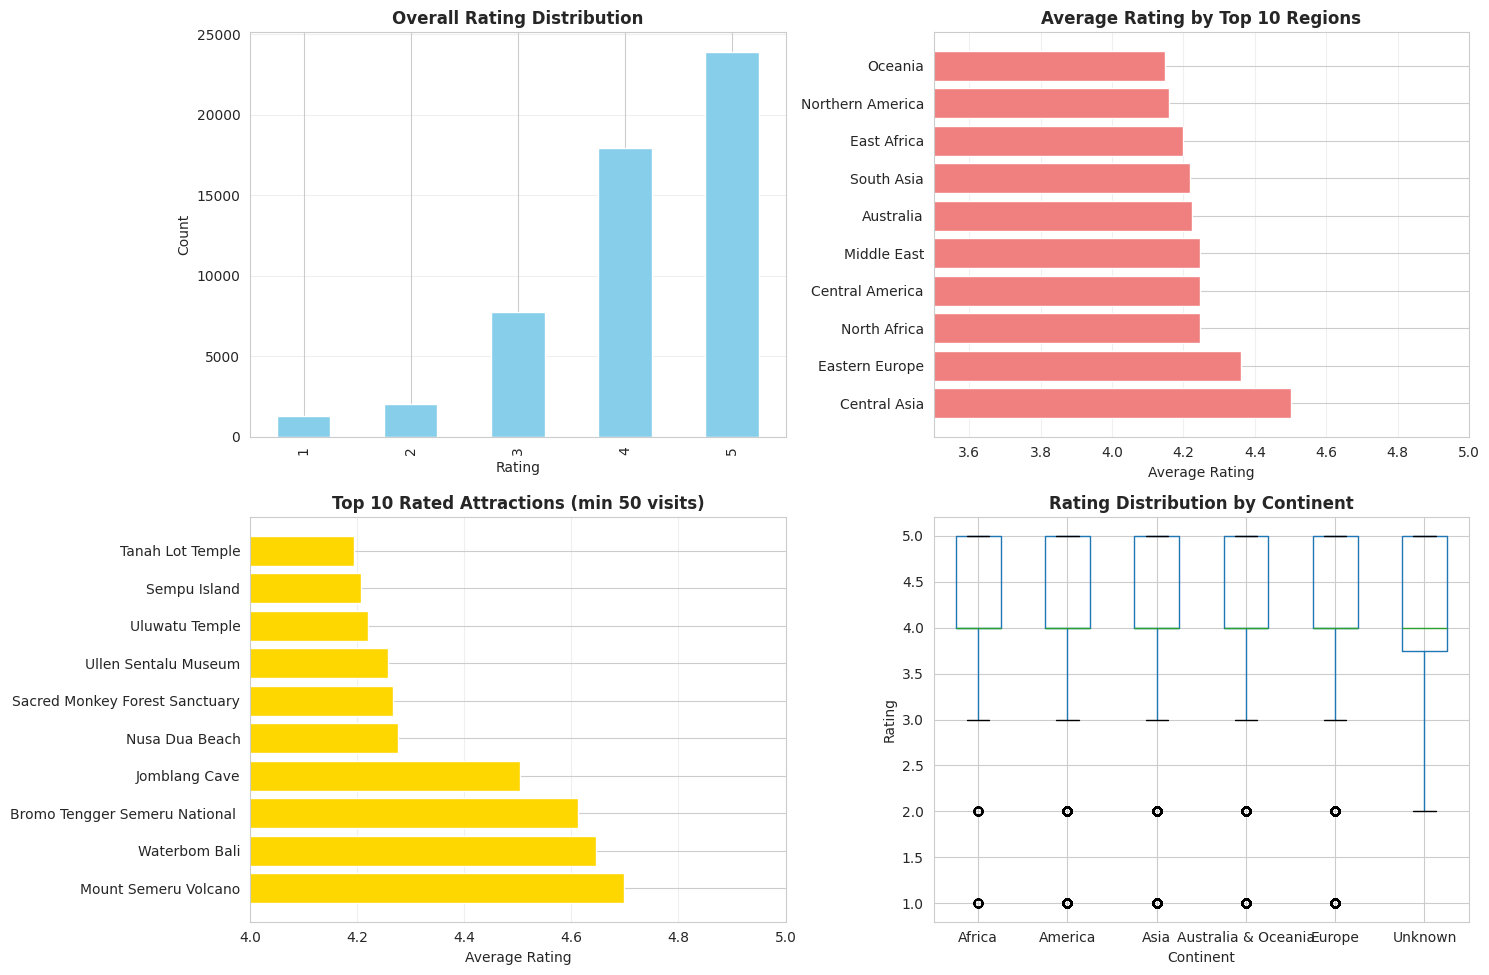

-> Saved: eda_rating_distributions.png


In [18]:
# Rating distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall rating distribution
df['Rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Overall Rating Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(axis='y', alpha=0.3)

# Rating by region (top 10)
region_rating = df.groupby('UserRegion')['Rating'].mean().sort_values(ascending=False).head(10)
axes[0, 1].barh(region_rating.index, region_rating.values, color='lightcoral')
axes[0, 1].set_title('Average Rating by Top 10 Regions', fontweight='bold')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_xlim([3.5, 5])
axes[0, 1].grid(axis='x', alpha=0.3)

# Top 10 attractions by rating (min 50 visits)
attr_stats = df.groupby('Attraction').agg({'Rating': ['mean', 'count']})
attr_stats.columns = ['avg_rating', 'count']
top_rated = attr_stats[attr_stats['count'] >= 50].sort_values('avg_rating', ascending=False).head(10)
axes[1, 0].barh(range(len(top_rated)), top_rated['avg_rating'].values, color='gold')
axes[1, 0].set_yticks(range(len(top_rated)))
axes[1, 0].set_yticklabels([name[:30] for name in top_rated.index])
axes[1, 0].set_title('Top 10 Rated Attractions (min 50 visits)', fontweight='bold')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_xlim([4, 5])
axes[1, 0].grid(axis='x', alpha=0.3)

# Rating distribution by continent (boxplot)
df.boxplot(column='Rating', by='UserContinent', ax=axes[1, 1])
axes[1, 1].set_title('Rating Distribution by Continent', fontweight='bold')
axes[1, 1].set_xlabel('Continent')
axes[1, 1].set_ylabel('Rating')
plt.suptitle('')

plt.tight_layout()
plt.savefig('eda_rating_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("-> Saved: eda_rating_distributions.png")

### **3.6 Interactive Plotly Visualization**

In [19]:
# Interactive top 10 attractions
top_10 = df['Attraction'].value_counts().head(10)

fig = px.bar(
    x=top_10.values,
    y=top_10.index,
    orientation='h',
    title='Top 10 Most Visited Attractions',
    labels={'x': 'Number of Visits', 'y': 'Attraction'},
    color=top_10.values,
    color_continuous_scale='Blues'
)

fig.update_layout(
    height=500,
    showlegend=False,
    title_font_size=16
)

fig.show()

print("-> EDA completed - 4 static visualizations + 1 interactive created")

-> EDA completed - 4 static visualizations + 1 interactive created


---
# 4️⃣ **MODEL TRAINING**

## Requirements:
- Regression: Predict ratings (Random Forest, XGBoost, LightGBM)
- Classification: Predict VisitMode (Random Forest, XGBoost, LightGBM)
- Recommendation: Collaborative filtering + Content-based

### **4.1 Regression Task - Rating Prediction**

In [20]:
print("="*80)
print("REGRESSION: Rating Prediction")
print("="*80 + "\n")

# Prepare features
feature_cols = [
    'VisitYear', 'VisitMonth', 'ContinentId', 'RegionId',
    'CountryId', 'AttractionTypeId', 'user_avg_rating',
    'user_rating_std', 'user_visit_count', 'attraction_avg_rating',
    'attraction_rating_std', 'attraction_visit_count',
    'Season_encoded', 'Quarter', 'user_visit_frequency',
    'user_attraction_diversity', 'attraction_popularity_score'
]

# Filter to available columns
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].fillna(0)
y = df['Rating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(feature_cols)}\n")

regression_results = {}

REGRESSION: Rating Prediction

Training samples: 42,344
Test samples: 10,586
Features: 17



In [21]:
# Train Random Forest
print("Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
regression_results['RandomForest'] = {
    'model': rf_reg,
    'r2': r2_score(y_test, y_pred_rf),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'mae': mean_absolute_error(y_test, y_pred_rf)
}
print(f"  R² = {regression_results['RandomForest']['r2']:.4f}, RMSE = {regression_results['RandomForest']['rmse']:.4f}")

Training Random Forest Regressor...
  R² = 0.7295, RMSE = 0.5047


In [22]:
# Train XGBoost
print("\nTraining XGBoost Regressor...")
xgb_reg = XGBRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_test)
regression_results['XGBoost'] = {
    'model': xgb_reg,
    'r2': r2_score(y_test, y_pred_xgb),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    'mae': mean_absolute_error(y_test, y_pred_xgb)
}
print(f"  R² = {regression_results['XGBoost']['r2']:.4f}, RMSE = {regression_results['XGBoost']['rmse']:.4f}")


Training XGBoost Regressor...
  R² = 0.7197, RMSE = 0.5138


In [23]:
# Train LightGBM
print("\nTraining LightGBM Regressor...")
lgbm_reg = LGBMRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1, verbose=-1)
lgbm_reg.fit(X_train, y_train)

y_pred_lgbm = lgbm_reg.predict(X_test)
regression_results['LightGBM'] = {
    'model': lgbm_reg,
    'r2': r2_score(y_test, y_pred_lgbm),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lgbm)),
    'mae': mean_absolute_error(y_test, y_pred_lgbm)
}
print(f"  R² = {regression_results['LightGBM']['r2']:.4f}, RMSE = {regression_results['LightGBM']['rmse']:.4f}")


Training LightGBM Regressor...
  R² = 0.7531, RMSE = 0.4822


In [24]:
# Select best model
best_reg_name = max(regression_results, key=lambda x: regression_results[x]['r2'])
best_reg_model = regression_results[best_reg_name]['model']

print(f"\n-> Best Regression Model: {best_reg_name}")
print(f"  R² = {regression_results[best_reg_name]['r2']:.4f}")
print(f"  RMSE = {regression_results[best_reg_name]['rmse']:.4f}")
print(f"  MAE = {regression_results[best_reg_name]['mae']:.4f}")


-> Best Regression Model: LightGBM
  R² = 0.7531
  RMSE = 0.4822
  MAE = 0.2451


### **4.2 Classification Task - Visit Mode Prediction**

In [25]:
print("\n" + "="*80)
print("CLASSIFICATION: Visit Mode Prediction")
print("="*80 + "\n")

# Prepare data
df_class = df[df['VisitModeName'].notna()].copy()

feature_cols_class = [
    'VisitYear', 'VisitMonth', 'ContinentId', 'RegionId',
    'CountryId', 'AttractionTypeId', 'user_avg_rating',
    'user_visit_count', 'attraction_avg_rating', 'attraction_visit_count',
    'Season_encoded', 'user_visit_frequency', 'user_attraction_diversity'
]

feature_cols_class = [col for col in feature_cols_class if col in df_class.columns]

X_class = df_class[feature_cols_class].fillna(0)
y_class = df_class['VisitModeName_encoded']

# Split with stratification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Training samples: {len(X_train_c):,}")
print(f"Test samples: {len(X_test_c):,}")
print(f"Features: {len(feature_cols_class)}")
print(f"Classes: {df_class['VisitModeName'].nunique()}\n")

classification_results = {}


CLASSIFICATION: Visit Mode Prediction

Training samples: 42,344
Test samples: 10,586
Features: 13
Classes: 5



In [26]:
# Train Random Forest
print("Training Random Forest Classifier...")
rf_class = RandomForestClassifier(
    n_estimators=100, max_depth=15, random_state=42,
    n_jobs=-1, class_weight='balanced'
)
rf_class.fit(X_train_c, y_train_c)

y_pred_rf_c = rf_class.predict(X_test_c)
classification_results['RandomForest'] = {
    'model': rf_class,
    'accuracy': accuracy_score(y_test_c, y_pred_rf_c),
    'f1': f1_score(y_test_c, y_pred_rf_c, average='weighted')
}
print(f"  Accuracy = {classification_results['RandomForest']['accuracy']:.4f}, F1 = {classification_results['RandomForest']['f1']:.4f}")

Training Random Forest Classifier...
  Accuracy = 0.4923, F1 = 0.4926


In [27]:
# Train XGBoost
print("\nTraining XGBoost Classifier...")
xgb_class = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
xgb_class.fit(X_train_c, y_train_c)

y_pred_xgb_c = xgb_class.predict(X_test_c)
classification_results['XGBoost'] = {
    'model': xgb_class,
    'accuracy': accuracy_score(y_test_c, y_pred_xgb_c),
    'f1': f1_score(y_test_c, y_pred_xgb_c, average='weighted')
}
print(f"  Accuracy = {classification_results['XGBoost']['accuracy']:.4f}, F1 = {classification_results['XGBoost']['f1']:.4f}")


Training XGBoost Classifier...
  Accuracy = 0.5157, F1 = 0.4745


In [28]:
# Train LightGBM
print("\nTraining LightGBM Classifier...")
lgbm_class = LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1, verbose=-1)
lgbm_class.fit(X_train_c, y_train_c)

y_pred_lgbm_c = lgbm_class.predict(X_test_c)
classification_results['LightGBM'] = {
    'model': lgbm_class,
    'accuracy': accuracy_score(y_test_c, y_pred_lgbm_c),
    'f1': f1_score(y_test_c, y_pred_lgbm_c, average='weighted')
}
print(f"  Accuracy = {classification_results['LightGBM']['accuracy']:.4f}, F1 = {classification_results['LightGBM']['f1']:.4f}")


Training LightGBM Classifier...
  Accuracy = 0.5046, F1 = 0.4564


In [29]:
# Select best model
best_class_name = max(classification_results, key=lambda x: classification_results[x]['f1'])
best_class_model = classification_results[best_class_name]['model']

print(f"\n-> Best Classification Model: {best_class_name}")
print(f"  Accuracy = {classification_results[best_class_name]['accuracy']:.4f}")
print(f"  F1-Score = {classification_results[best_class_name]['f1']:.4f}")


-> Best Classification Model: RandomForest
  Accuracy = 0.4923
  F1-Score = 0.4926


### **4.3 Recommendation System - Collaborative Filtering**

In [30]:
print("\n" + "="*80)
print("RECOMMENDATION SYSTEM: Collaborative Filtering")
print("="*80 + "\n")

# Create user-item matrix
user_item_matrix = df.pivot_table(
    index='UserId',
    columns='AttractionId',
    values='Rating',
    fill_value=0
)

print(f"User-Item Matrix: {user_item_matrix.shape[0]:,} users × {user_item_matrix.shape[1]} attractions")

sparsity = (user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100
print(f"Sparsity: {sparsity:.2f}%\n")

# Train KNN model
print("Training K-Nearest Neighbors model...")
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=min(20, len(user_item_matrix)))
knn_model.fit(user_item_matrix.values)

print("\n-> Recommendation system built successfully")

# Store for later use
recommendation_system = {
    'model': knn_model,
    'user_item_matrix': user_item_matrix
}


RECOMMENDATION SYSTEM: Collaborative Filtering

User-Item Matrix: 33,530 users × 30 attractions
Sparsity: 95.50%

Training K-Nearest Neighbors model...

-> Recommendation system built successfully


### **4.4 Recommendation System - Content-Based Filtering**

In [31]:
print("\n" + "="*80)
print("RECOMMENDATION SYSTEM: Content-Based Filtering")
print("="*80 + "\n")

from sklearn.metrics.pairwise import cosine_similarity

# ── Build attraction feature matrix ──────────────────────────────────────────
# Use encoded attraction-level features as the content profile
attraction_features_df = df.groupby('AttractionId').agg(
    AttractionTypeId      = ('AttractionTypeId',      'first'),
    AttractionCityId      = ('AttractionCityId',      'first'),
    attraction_avg_rating = ('attraction_avg_rating',  'first'),
    attraction_visit_count= ('attraction_visit_count', 'first'),
    attraction_popularity = ('attraction_popularity_score', 'first')
).reset_index()

# Fill missing values
attraction_features_df = attraction_features_df.fillna(0)

# Scale features for similarity computation
from sklearn.preprocessing import MinMaxScaler as MMS
content_scaler = MMS()
content_feature_cols = ['AttractionTypeId', 'AttractionCityId',
                        'attraction_avg_rating', 'attraction_visit_count',
                        'attraction_popularity']
attraction_matrix = content_scaler.fit_transform(
    attraction_features_df[content_feature_cols]
)

# Compute item-item cosine similarity
item_similarity_matrix = cosine_similarity(attraction_matrix)
item_sim_df = pd.DataFrame(
    item_similarity_matrix,
    index=attraction_features_df['AttractionId'],
    columns=attraction_features_df['AttractionId']
)

print(f"Attraction Feature Matrix   : {attraction_matrix.shape[0]} attractions × {attraction_matrix.shape[1]} features")
print(f"Item-Similarity Matrix Shape: {item_sim_df.shape}")


# ── Content-based recommendation function ────────────────────────────────────
def get_content_recommendations(user_id, n_recommendations=5, exclude_ids=None):
    """Recommend attractions based on content similarity to what the user has visited.

    exclude_ids: optional set of AttractionIds to treat as unseen (for leave-one-out eval).
    """
    visited_all = set(df[df['UserId'] == user_id]['AttractionId'].unique().tolist())
    # For evaluation: temporarily pretend held-out items were not visited
    visited = visited_all - set(exclude_ids) if exclude_ids else visited_all

    if not visited:
        popular = df.groupby('AttractionId')['Rating'].count().sort_values(ascending=False)
        return popular.head(n_recommendations).index.tolist()

    # Aggregate similarity scores for all candidate attractions
    scores = {}
    for attr_id in visited:
        if attr_id not in item_sim_df.index:
            continue
        sim_scores = item_sim_df[attr_id]
        for cand_id, score in sim_scores.items():
            if cand_id not in visited:      # exclude still-visited items
                scores[cand_id] = scores.get(cand_id, 0) + score

    if not scores:
        popular = df.groupby('AttractionId')['Rating'].count().sort_values(ascending=False)
        return popular.head(n_recommendations).index.tolist()

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [aid for aid, _ in sorted_scores[:n_recommendations]]


# ── Demo ──────────────────────────────────────────────────────────────────────
test_user_cb = df['UserId'].iloc[10]
print(f"\nContent-Based Recommendations for User {test_user_cb}:")

visited_names = df[df['UserId'] == test_user_cb]['Attraction'].unique()[:3]
print(f"  Past visits (sample): {list(visited_names)}")

cb_recs = get_content_recommendations(test_user_cb, n_recommendations=5)
print("\nTop 5 Content-Based Recommendations:")
for i, attr_id in enumerate(cb_recs, 1):
    rows = df[df['AttractionId'] == attr_id]
    if not rows.empty:
        attr_name = rows['Attraction'].iloc[0]
        attr_type = rows['AttractionType'].iloc[0]
        avg_r     = rows['attraction_avg_rating'].iloc[0]
        print(f"  {i}. {attr_name} ({attr_type}) — avg rating: {avg_r:.2f}")

# Store for evaluation & deployment
content_based_system = {
    'item_similarity': item_sim_df,
    'attraction_features': attraction_features_df,
    'content_scaler': content_scaler
}

print("\n-> Content-based filtering built successfully")


RECOMMENDATION SYSTEM: Content-Based Filtering

Attraction Feature Matrix   : 30 attractions × 5 features
Item-Similarity Matrix Shape: (30, 30)

Content-Based Recommendations for User 86054:
  Past visits (sample): ['Sacred Monkey Forest Sanctuary', 'Uluwatu Temple', 'Tegalalang Rice Terrace']

Top 5 Content-Based Recommendations:
  1. Waterbom Bali (Water Parks) — avg rating: 4.65
  2. Tanah Lot Temple (Religious Sites) — avg rating: 4.19
  3. Seminyak Beach (Beaches) — avg rating: 3.80
  4. Sanur Beach (Beaches) — avg rating: 3.98
  5. Mount Semeru Volcano (Volcanos) — avg rating: 4.70

-> Content-based filtering built successfully


---
# 5️⃣ **MODEL EVALUATION**

## Requirements:
- Classification: Accuracy, Precision, Recall, F1-Score
- Regression: R², MSE, RMSE, MAE
- Recommendation: MAP or RMSE

### **5.1 Regression Model Evaluation**

REGRESSION MODEL EVALUATION

       Model       R²     RMSE      MAE
    LightGBM 0.753075 0.482243 0.245104
RandomForest 0.729536 0.504705 0.248106
     XGBoost 0.719678 0.513821 0.255530


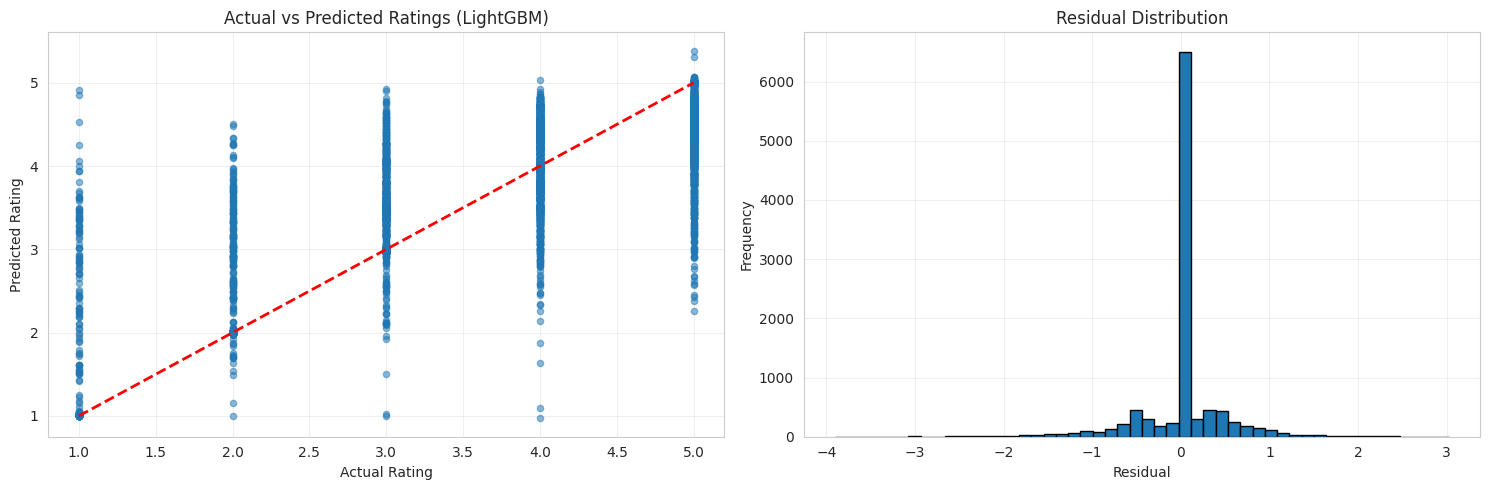

In [32]:
print("="*80)
print("REGRESSION MODEL EVALUATION")
print("="*80 + "\n")

# Compare all models
comparison_reg = []
for name, results in regression_results.items():
    comparison_reg.append({
        'Model': name,
        'R²': results['r2'],
        'RMSE': results['rmse'],
        'MAE': results['mae']
    })

comp_df_reg = pd.DataFrame(comparison_reg).sort_values('R²', ascending=False)
print(comp_df_reg.to_string(index=False))

# Visualize actual vs predicted
best_predictions = regression_results[best_reg_name]['model'].predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.5, s=20)
axes[0].plot([1, 5], [1, 5], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Actual vs Predicted Ratings ({best_reg_name})')
axes[0].grid(alpha=0.3)

# Residuals
residuals = y_test - best_predictions
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### **5.2 Classification Model Evaluation**


CLASSIFICATION MODEL EVALUATION

       Model  Accuracy  F1-Score
RandomForest  0.492254  0.492569
     XGBoost  0.515681  0.474541
    LightGBM  0.504629  0.456384

Detailed Classification Report:
              precision    recall  f1-score   support

    Business       0.13      0.39      0.19       125
     Couples       0.55      0.62      0.59      4324
      Family       0.57      0.48      0.52      3043
     Friends       0.42      0.33      0.37      2189
        Solo       0.27      0.30      0.28       905

    accuracy                           0.49     10586
   macro avg       0.39      0.43      0.39     10586
weighted avg       0.50      0.49      0.49     10586



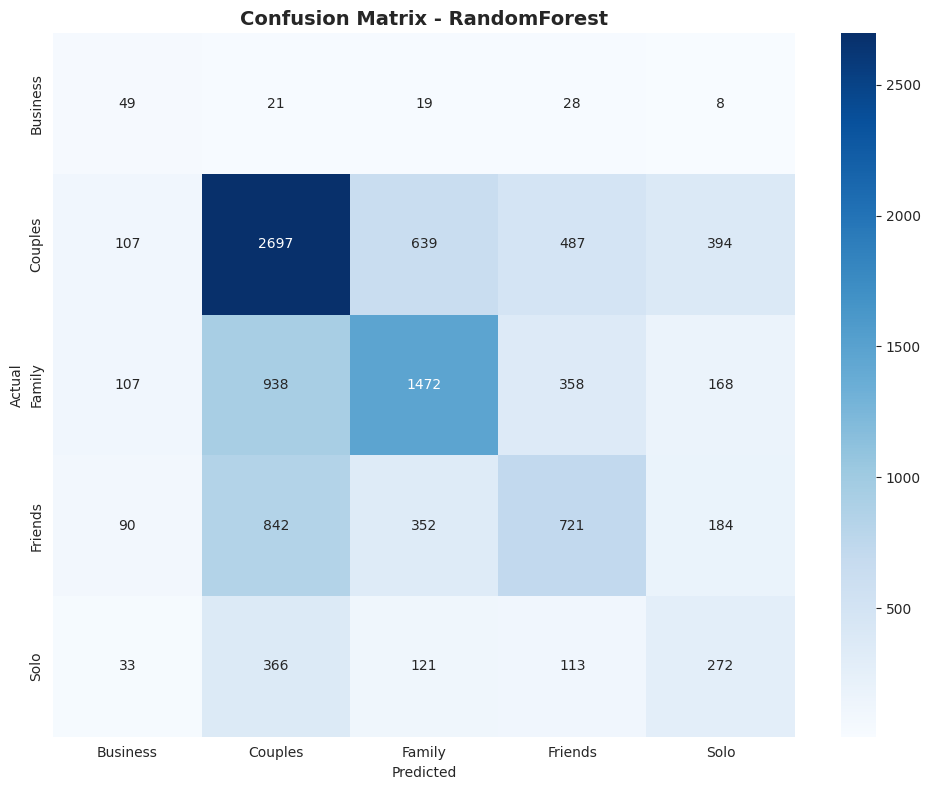

In [33]:
print("\n" + "="*80)
print("CLASSIFICATION MODEL EVALUATION")
print("="*80 + "\n")

# Compare all models
comparison_class = []
for name, results in classification_results.items():
    comparison_class.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'F1-Score': results['f1']
    })

comp_df_class = pd.DataFrame(comparison_class).sort_values('F1-Score', ascending=False)
print(comp_df_class.to_string(index=False))

# Detailed report
y_pred_best = best_class_model.predict(X_test_c)
class_names = encoders['VisitModeName'].classes_

print("\nDetailed Classification Report:")
print(classification_report(y_test_c, y_pred_best, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_class_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### **5.3 Recommendation System Evaluation — MAP & RMSE**


RECOMMENDATION SYSTEM EVALUATION — MAP, NDCG & RMSE

Eligible users for evaluation : 304
Sampled for this run          : 300
Evaluation @K=10, retrieving top-20

Metric                                     Collaborative Content-Based
──────────────────────────────────────────────────────────────────────
MAP@10 (Mean Avg Precision)                       0.2890        0.4907
NDCG@10 (Norm. Disc. Cum. Gain)                   0.3232        0.5960
Hit Rate@10 (held-out item in top-10)             0.4233        0.9233
RMSE (collaborative rating prediction)            0.5743           N/A

Note: Leave-one-out split | held-out = 1 item rated >=4 per user | @K=10


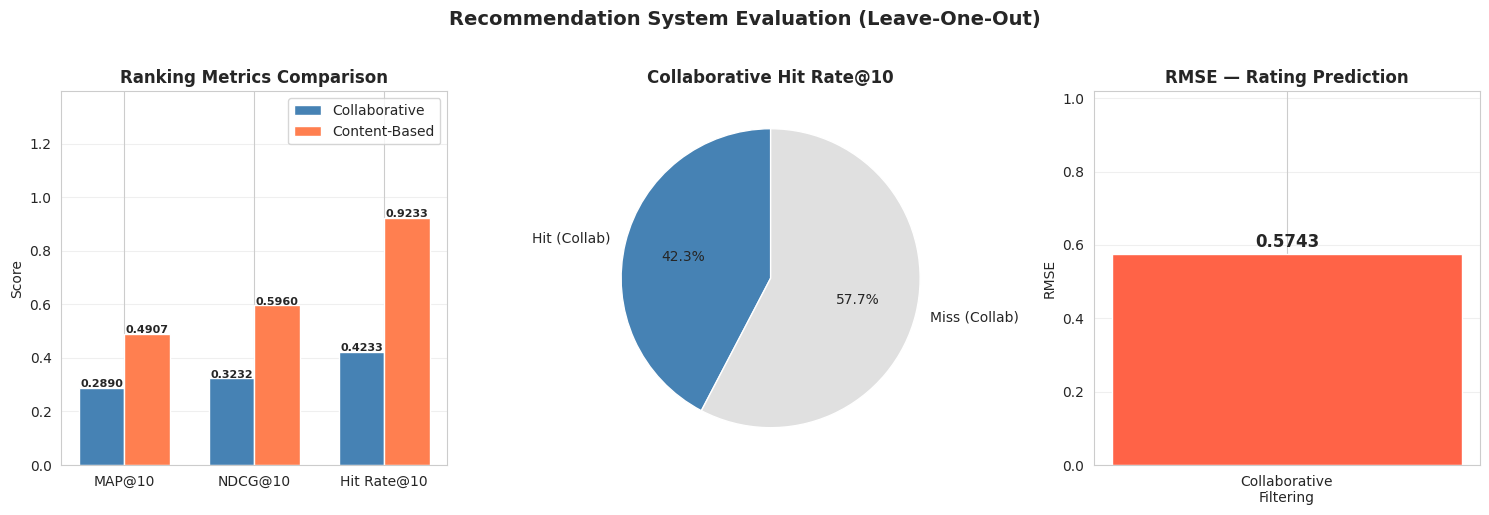


-> Saved: recommendation_evaluation.png

-> Recommendation evaluation completed


In [34]:
print("\n" + "="*80)
print("RECOMMENDATION SYSTEM EVALUATION — MAP, NDCG & RMSE")
print("="*80 + "\n")

# CORRECT APPROACH — proper leave-one-out:
#   1. For each eval user, hold out 1 high-rated item
#   2. Temporarily zero it out in the user-item matrix
#   3. Run the recommender → it can now surface the held-out item
#   4. Check if held-out item appears in top-K → compute MAP, NDCG, Hit Rate
#   5. Restore the matrix entry for the next user

import math, copy

def average_precision_at_k(recommended, relevant_set, k=10):
    if not relevant_set:
        return 0.0
    hits, score = 0, 0.0
    for rank, item in enumerate(recommended[:k], start=1):
        if item in relevant_set:
            hits += 1
            score += hits / rank
    return score / min(len(relevant_set), k)

def ndcg_at_k(recommended, relevant_set, k=10):
    dcg   = sum(1/math.log2(r+1) for r,it in enumerate(recommended[:k],1) if it in relevant_set)
    ideal = sum(1/math.log2(r+1) for r in range(1, min(len(relevant_set), k)+1))
    return dcg / ideal if ideal > 0 else 0.0

# ── Setup ─────────────────────────────────────────────────────────────────────
np.random.seed(42)
K           = 10          # evaluate @K
N_RETRIEVE  = 20          # how many to retrieve before slicing @K
uim         = recommendation_system['user_item_matrix'].copy()   # work on a copy

# Eligible users: visited >=5 attractions, at least 1 rated >=4
eligible_mask = (
    df.groupby('UserId')
    .apply(lambda g: len(g.drop_duplicates('AttractionId')) >= 5
                     and g['Rating'].ge(4).sum() >= 1)
)
eligible_users = eligible_mask[eligible_mask].index.tolist()
eval_users = np.random.choice(
    eligible_users, size=min(300, len(eligible_users)), replace=False
)
print(f"Eligible users for evaluation : {len(eligible_users):,}")
print(f"Sampled for this run          : {len(eval_users)}")
print(f"Evaluation @K={K}, retrieving top-{N_RETRIEVE}\n")

# ── Evaluation loop ───────────────────────────────────────────────────────────
map_collab_list, ndcg_collab_list, hr_collab_list   = [], [], []
map_content_list, ndcg_content_list, hr_content_list = [], [], []
rmse_list = []

for uid in eval_users:
    if uid not in uim.index:
        continue

    user_ratings = df[df['UserId'] == uid][['AttractionId','Rating']].drop_duplicates('AttractionId')
    high_rated   = user_ratings[user_ratings['Rating'] >= 4]
    if high_rated.empty:
        continue

    # Pick ONE held-out item
    hold_row    = high_rated.sample(1, random_state=int(uid) % 10000)
    hold_id     = hold_row['AttractionId'].iloc[0]
    hold_rating = float(hold_row['Rating'].iloc[0])
    relevant    = {hold_id}

    # ── Leave-one-out: zero the held-out entry ──────────────────────────────
    u_idx = uim.index.get_loc(uid)
    col_idx = uim.columns.get_loc(hold_id) if hold_id in uim.columns else None

    if col_idx is not None:
        original_val = uim.iat[u_idx, col_idx]
        uim.iat[u_idx, col_idx] = 0          # temporarily remove

    # ── Collaborative recs (using modified matrix) ──────────────────────────
    def get_collab_recs_eval(uid, n):
        if uid not in uim.index:
            return []
        uidx = uim.index.get_loc(uid)
        dists, idxs = recommendation_system['model'].kneighbors(
            uim.iloc[uidx].values.reshape(1,-1), n_neighbors=min(15, len(uim))
        )
        scores = {}
        for sim_idx in idxs.flatten()[1:]:
            for ci, rating in enumerate(uim.iloc[sim_idx]):
                if rating > 0 and uim.iat[uidx, ci] == 0:
                    aid = uim.columns[ci]
                    scores.setdefault(aid, []).append(rating)
        avg = {aid: np.mean(r) for aid, r in scores.items()}
        return [aid for aid,_ in sorted(avg.items(), key=lambda x:x[1], reverse=True)[:n]]

    collab_recs = get_collab_recs_eval(uid, N_RETRIEVE)

    # ── Restore matrix entry ────────────────────────────────────────────────
    if col_idx is not None:
        uim.iat[u_idx, col_idx] = original_val

    # ── Content-based recs: exclude held-out item so it can be surfaced ────────
    try:
        content_recs = get_content_recommendations(
            uid, n_recommendations=N_RETRIEVE, exclude_ids={hold_id}
        )
    except Exception:
        content_recs = []

    # ── Metrics ──────────────────────────────────────────────────────────────
    map_collab_list.append(average_precision_at_k(collab_recs,  relevant, K))
    map_content_list.append(average_precision_at_k(content_recs, relevant, K))
    ndcg_collab_list.append(ndcg_at_k(collab_recs,  relevant, K))
    ndcg_content_list.append(ndcg_at_k(content_recs, relevant, K))
    hr_collab_list.append(int(hold_id in collab_recs[:K]))
    hr_content_list.append(int(hold_id in content_recs[:K]))

    # ── RMSE: weighted neighbour prediction for held-out item ────────────────
    if col_idx is not None and uid in uim.index:
        uidx = uim.index.get_loc(uid)
        dists, idxs = recommendation_system['model'].kneighbors(
            uim.iloc[uidx].values.reshape(1,-1), n_neighbors=min(15, len(uim))
        )
        sims = 1 - dists.flatten()[1:]
        nbr_r, nbr_w = [], []
        for nidx, w in zip(idxs.flatten()[1:], sims):
            r = uim.iat[nidx, col_idx]
            if r > 0:
                nbr_r.append(r); nbr_w.append(w)
        if nbr_r and sum(nbr_w) > 0:
            pred = np.average(nbr_r, weights=nbr_w)
            rmse_list.append((pred - hold_rating)**2)

# ── Aggregate ─────────────────────────────────────────────────────────────────
def sm(lst): return float(np.mean(lst)) if lst else float('nan')

map_c   = sm(map_collab_list);   map_cb  = sm(map_content_list)
ndcg_c  = sm(ndcg_collab_list);  ndcg_cb = sm(ndcg_content_list)
hr_c    = sm(hr_collab_list);    hr_cb   = sm(hr_content_list)
rmse_c  = float(np.sqrt(sm(rmse_list))) if rmse_list else float('nan')

print(f"{'Metric':<42} {'Collaborative':>13} {'Content-Based':>13}")
print("─" * 70)
print(f"{'MAP@'+str(K)+' (Mean Avg Precision)':<42} {map_c:>13.4f} {map_cb:>13.4f}")
print(f"{'NDCG@'+str(K)+' (Norm. Disc. Cum. Gain)':<42} {ndcg_c:>13.4f} {ndcg_cb:>13.4f}")
print(f"{'Hit Rate@'+str(K)+' (held-out item in top-'+str(K)+')':<42} {hr_c:>13.4f} {hr_cb:>13.4f}")
print(f"{'RMSE (collaborative rating prediction)':<42} {rmse_c:>13.4f} {'N/A':>13}")
print()
print(f"Note: Leave-one-out split | held-out = 1 item rated >=4 per user | @K={K}")

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics  = [f'MAP@{K}', f'NDCG@{K}', f'Hit Rate@{K}']
collab_v = [map_c, ndcg_c, hr_c]
content_v= [map_cb, ndcg_cb, hr_cb]
x        = np.arange(3)
w        = 0.35

bars1 = axes[0].bar(x - w/2, collab_v,  w, label='Collaborative', color='steelblue')
bars2 = axes[0].bar(x + w/2, content_v, w, label='Content-Based', color='coral')
axes[0].set_xticks(x); axes[0].set_xticklabels(metrics, fontsize=10)
axes[0].set_title('Ranking Metrics Comparison', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Score')
axes[0].legend(); axes[0].grid(axis='y', alpha=0.3)
ymax = max(collab_v + content_v)
axes[0].set_ylim(0, ymax * 1.5 + 0.01)
for b in list(bars1) + list(bars2):
    axes[0].text(b.get_x()+b.get_width()/2, b.get_height()+0.001,
                 f'{b.get_height():.4f}', ha='center', fontsize=8, fontweight='bold')

# Hit Rate pie breakdown
labels = ['Hit (Collab)', 'Miss (Collab)']
axes[1].pie([hr_c, 1-hr_c], labels=labels, autopct='%1.1f%%',
            colors=['steelblue','#e0e0e0'], startangle=90)
axes[1].set_title(f'Collaborative Hit Rate@{K}', fontweight='bold', fontsize=12)

# RMSE bar
axes[2].bar(['Collaborative\nFiltering'], [rmse_c if not np.isnan(rmse_c) else 0],
            color='tomato', width=0.35)
axes[2].set_title('RMSE — Rating Prediction', fontweight='bold', fontsize=12)
axes[2].set_ylabel('RMSE')
yval = rmse_c if not np.isnan(rmse_c) else 0
axes[2].set_ylim(0, yval * 1.6 + 0.1)
axes[2].text(0, yval + 0.02, f'{yval:.4f}', ha='center', fontweight='bold', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Recommendation System Evaluation (Leave-One-Out)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('recommendation_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n-> Saved: recommendation_evaluation.png")
print("\n-> Recommendation evaluation completed")

---
# 6️⃣ **DEPLOYMENT PREPARATION**

Save models and data for Streamlit deployment

In [35]:
import pickle

print("="*80)
print("UPDATING DEPLOYMENT PACKAGE WITH CONTENT-BASED SYSTEM")
print("="*80 + "\n")

deployment_package = {
    # Regression
    'regression_model':       best_reg_model,
    'regression_model_name':  best_reg_name,
    'regression_features':    feature_cols,
    'regression_performance': regression_results[best_reg_name],

    # Classification
    'classification_model':       best_class_model,
    'classification_model_name':  best_class_name,
    'classification_features':    feature_cols_class,
    'classification_performance': classification_results[best_class_name],
    'classification_encoder':     encoders['VisitModeName'],

    # Collaborative Filtering
    'recommendation_knn':  recommendation_system['model'],
    'user_item_matrix':    recommendation_system['user_item_matrix'],

    # Content-Based Filtering  ← NEW
    'item_similarity':        content_based_system['item_similarity'],
    'attraction_features':    content_based_system['attraction_features'],
    'content_scaler':         content_based_system['content_scaler'],

    # Shared utilities
    'encoders':        encoders,
    'scaler_standard': scaler_standard,
    'scaler_minmax':   scaler_minmax,

    # Reference data
    'df_attractions': df[['AttractionId','Attraction','AttractionType',
                           'AttractionCityName','attraction_avg_rating',
                           'attraction_visit_count']].drop_duplicates('AttractionId'),
    'df_users':       df[['UserId','UserContinent','UserCountry',
                           'UserRegion']].drop_duplicates('UserId'),
}

with open('tourism_models.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

df.to_csv('preprocessed_tourism_data.csv', index=False)
comp_df_reg.to_csv('regression_comparison.csv',   index=False)
comp_df_class.to_csv('classification_comparison.csv', index=False)

print("-> Saved tourism_models.pkl  (includes content-based system)")
print("-> Saved preprocessed_tourism_data.csv")
print("-> Saved regression_comparison.csv")
print("-> Saved classification_comparison.csv")
print("\n-> All files ready for Streamlit deployment!")

UPDATING DEPLOYMENT PACKAGE WITH CONTENT-BASED SYSTEM

-> Saved tourism_models.pkl  (includes content-based system)
-> Saved preprocessed_tourism_data.csv
-> Saved regression_comparison.csv
-> Saved classification_comparison.csv

-> All files ready for Streamlit deployment!


## **Streamlit Deployment**

To deploy the Streamlit application and make it accessible, we'll use `ngrok` to create a public URL for our local Streamlit server.

First, let's install the necessary libraries: `streamlit` and `pyngrok`.

In [36]:
%%capture
!pip install streamlit pyngrok

Next, we'll create a Python file for our Streamlit application (`tourism_app.py`).

In [37]:
%%writefile tourism_app.py
"""
Tourism Analytics — Streamlit Application
==========================================
Provides:
  1. Predicted Visit Mode  (classification)
  2. Predicted Attraction Rating  (regression)
  3. Personalized Recommendations — Collaborative + Content-Based
  4. Analytics Dashboard — popular attractions, regions, user segments
"""

import streamlit as st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg")
import warnings
warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────────────────────
# Page config
# ──────────────────────────────────────────────────────────────────────────────
st.set_page_config(
    page_title="Tourism Analytics",
    page_icon="🌍",
    layout="wide",
    initial_sidebar_state="expanded",
)

# ──────────────────────────────────────────────────────────────────────────────
# Load models / data
# ──────────────────────────────────────────────────────────────────────────────
@st.cache_resource
def load_models():
    with open("tourism_models.pkl", "rb") as f:
        pkg = pickle.load(f)
    return pkg

@st.cache_data
def load_data():
    return pd.read_csv("preprocessed_tourism_data.csv")

# ──────────────────────────────────────────────────────────────────────────────
# Recommendation helpers
# ──────────────────────────────────────────────────────────────────────────────
def collab_recommend(user_id, pkg, df, n=5):
    uim = pkg["user_item_matrix"]
    knn = pkg["recommendation_knn"]
    if user_id not in uim.index:
        popular = df["AttractionId"].value_counts().head(n)
        return popular.index.tolist()
    u_idx = uim.index.get_loc(user_id)
    distances, indices = knn.kneighbors(
        uim.iloc[u_idx].values.reshape(1, -1),
        n_neighbors=min(15, len(uim)),
    )
    scores = {}
    for sim_idx in indices.flatten()[1:]:
        for col_idx, rating in enumerate(uim.iloc[sim_idx]):
            if rating > 0:
                aid = uim.columns[col_idx]
                if uim.iloc[u_idx, col_idx] == 0:
                    scores.setdefault(aid, []).append(rating)
    avg = {aid: np.mean(r) for aid, r in scores.items()}
    return [aid for aid, _ in sorted(avg.items(), key=lambda x: x[1], reverse=True)[:n]]


def content_recommend(user_id, pkg, df, n=5):
    visited = df[df["UserId"] == user_id]["AttractionId"].unique().tolist()
    sim_df  = pkg["item_similarity"]
    if not visited:
        popular = df["AttractionId"].value_counts().head(n)
        return popular.index.tolist()
    scores = {}
    for aid in visited:
        if aid not in sim_df.index:
            continue
        for cand, score in sim_df[aid].items():
            if cand not in visited:
                scores[cand] = scores.get(cand, 0) + score
    if not scores:
        popular = df["AttractionId"].value_counts().head(n)
        return popular.index.tolist()
    return [aid for aid, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n]]


def enrich_recs(rec_ids, df):
    rows = []
    attr_df = df[["AttractionId", "Attraction", "AttractionType",
                  "AttractionCityName", "attraction_avg_rating",
                  "attraction_visit_count"]].drop_duplicates("AttractionId")
    for aid in rec_ids:
        r = attr_df[attr_df["AttractionId"] == aid]
        if not r.empty:
            rows.append(r.iloc[0].to_dict())
    return pd.DataFrame(rows)

# ──────────────────────────────────────────────────────────────────────────────
# ── SIDEBAR ──────────────────────────────────────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────────
st.sidebar.image("https://img.icons8.com/fluency/96/globe.png", width=72)
st.sidebar.title("🌍 Tourism Analytics")
page = st.sidebar.radio(
    "Navigate",
    ["🏠 Home", "🔮 Predictions", "🎯 Recommendations", "📊 Analytics Dashboard"],
)

# ──────────────────────────────────────────────────────────────────────────────
# Try loading — show friendly error if files missing
# ──────────────────────────────────────────────────────────────────────────────
try:
    pkg = load_models()
    df  = load_data()
    models_loaded = True
except FileNotFoundError:
    models_loaded = False

# ══════════════════════════════════════════════════════════════════════════════
# HOME
# ══════════════════════════════════════════════════════════════════════════════
if page == "🏠 Home":
    st.title("🌍 Tourism Analytics Platform")
    st.markdown(
        """
        Welcome! This platform uses **machine learning** to help travel agencies and tourists
        make smarter decisions.

        ### What can you do here?
        | Page | Description |
        |------|-------------|
        | 🔮 **Predictions** | Predict a user's visit mode and expected attraction rating |
        | 🎯 **Recommendations** | Get personalised attraction suggestions |
        | 📊 **Analytics Dashboard** | Explore tourism trends, top attractions, and user segments |
        """
    )

    if models_loaded:
        c1, c2, c3, c4 = st.columns(4)
        c1.metric("Total Records",    f"{len(df):,}")
        c2.metric("Unique Users",     f"{df['UserId'].nunique():,}")
        c3.metric("Attractions",      f"{df['AttractionId'].nunique()}")
        c4.metric("Avg Rating",       f"{df['Rating'].mean():.2f} / 5")

        st.markdown("---")
        st.subheader("Model Performance Summary")
        col1, col2 = st.columns(2)
        with col1:
            reg_p = pkg["regression_performance"]
            st.info(
                f"**Regression Model** ({pkg['regression_model_name']})\n\n"
                f"R² = `{reg_p['r2']:.4f}` | RMSE = `{reg_p['rmse']:.4f}` | MAE = `{reg_p['mae']:.4f}`"
            )
        with col2:
            cls_p = pkg["classification_performance"]
            st.success(
                f"**Classification Model** ({pkg['classification_model_name']})\n\n"
                f"Accuracy = `{cls_p['accuracy']:.4f}` | F1 = `{cls_p['f1']:.4f}`"
            )
    else:
        st.warning(
            "⚠️ Model files not found. Please run the notebook first to generate "
            "`tourism_models.pkl` and `preprocessed_tourism_data.csv`, then place them "
            "in the same folder as this app."
        )

# ══════════════════════════════════════════════════════════════════════════════
# PREDICTIONS
# ══════════════════════════════════════════════════════════════════════════════
elif page == "🔮 Predictions":
    st.title("🔮 Predictions")
    if not models_loaded:
        st.error("Model files not loaded. Run the notebook first.")
        st.stop()

    st.markdown("Fill in the details below to get predictions.")

    col1, col2 = st.columns(2)
    with col1:
        st.subheader("User Details")
        continent_opts = sorted(df["UserContinent"].dropna().unique())
        continent      = st.selectbox("Continent", continent_opts)
        country_opts   = sorted(df[df["UserContinent"] == continent]["UserCountry"].dropna().unique())
        country        = st.selectbox("Country", country_opts)
        region_opts    = sorted(df[df["UserCountry"] == country]["UserRegion"].dropna().unique())
        region         = st.selectbox("Region", region_opts if region_opts else ["Unknown"])

    with col2:
        st.subheader("Visit & Attraction Details")
        year  = st.slider("Visit Year",  2010, 2025, 2023)
        month = st.slider("Visit Month", 1, 12, 6)
        attraction_type_opts = sorted(df["AttractionType"].dropna().unique())
        attr_type = st.selectbox("Attraction Type", attraction_type_opts)

    # Build feature vector
    def get_feature_vector(feature_list):
        enc = pkg["encoders"]
        season_map = {**{m: "Winter" for m in [12,1,2]},
                      **{m: "Spring" for m in [3,4,5]},
                      **{m: "Summer" for m in [6,7,8]},
                      **{m: "Fall"   for m in [9,10,11]}}
        season = season_map[month]

        def safe_encode(encoder_key, value):
            le = enc.get(encoder_key)
            if le is None: return 0
            classes = list(le.classes_)
            return classes.index(value) if value in classes else 0

        feat_map = {
            "VisitYear":                  year,
            "VisitMonth":                 month,
            "ContinentId":                safe_encode("UserContinent", continent),
            "RegionId":                   safe_encode("UserRegion",    region),
            "CountryId":                  safe_encode("UserCountry",   country),
            "AttractionTypeId":           safe_encode("AttractionType", attr_type),
            "user_avg_rating":            df["user_avg_rating"].mean(),
            "user_rating_std":            df["user_rating_std"].mean(),
            "user_visit_count":           df["user_visit_count"].mean(),
            "attraction_avg_rating":      df[df["AttractionType"] == attr_type]["attraction_avg_rating"].mean()
                                          if attr_type in df["AttractionType"].values
                                          else df["attraction_avg_rating"].mean(),
            "attraction_rating_std":      df["attraction_rating_std"].mean(),
            "attraction_visit_count":     df["attraction_visit_count"].mean(),
            "Season_encoded":             safe_encode("Season", season),
            "Quarter":                    (month - 1) // 3 + 1,
            "user_visit_frequency":       df["user_visit_frequency"].mean(),
            "user_attraction_diversity":  df["user_attraction_diversity"].mean(),
            "attraction_popularity_score": df["attraction_popularity_score"].mean(),
        }
        return np.array([feat_map.get(f, 0) for f in feature_list]).reshape(1, -1)

    if st.button("🔮 Generate Predictions", use_container_width=True):
        with st.spinner("Running models..."):
            # Rating prediction
            reg_feats = pkg["regression_features"]
            X_reg     = get_feature_vector(reg_feats)
            pred_rating = pkg["regression_model"].predict(X_reg)[0]
            pred_rating = float(np.clip(pred_rating, 1, 5))

            # Visit mode prediction
            cls_feats = pkg["classification_features"]
            X_cls     = get_feature_vector(cls_feats)
            pred_mode_enc = pkg["classification_model"].predict(X_cls)[0]
            le_mode   = pkg["classification_encoder"]
            pred_mode = le_mode.inverse_transform([pred_mode_enc])[0]

            # Probabilities
            if hasattr(pkg["classification_model"], "predict_proba"):
                proba = pkg["classification_model"].predict_proba(X_cls)[0]
                mode_classes = le_mode.classes_
            else:
                proba, mode_classes = None, []

        st.markdown("---")
        r1, r2 = st.columns(2)
        with r1:
            stars = "⭐" * round(pred_rating)
            st.success(f"### Predicted Rating\n## {pred_rating:.2f} / 5.0\n{stars}")
        with r2:
            mode_emoji = {"Business": "💼", "Family": "👨‍👩‍👧", "Couples": "💑",
                          "Friends": "👫", "Solo": "🧍"}.get(pred_mode, "✈️")
            st.info(f"### Predicted Visit Mode\n## {mode_emoji} {pred_mode}")

        if proba is not None and len(mode_classes):
            st.subheader("Visit Mode Probability Distribution")
            prob_df = pd.DataFrame({"Mode": mode_classes, "Probability": proba * 100})\
                        .sort_values("Probability", ascending=True)
            fig, ax = plt.subplots(figsize=(8, 3))
            colors = ["#4CAF50" if m == pred_mode else "#90CAF9" for m in prob_df["Mode"]]
            ax.barh(prob_df["Mode"], prob_df["Probability"], color=colors)
            ax.set_xlabel("Probability (%)")
            ax.set_title("Visit Mode Probabilities")
            ax.grid(axis="x", alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig)
            plt.close()

# ══════════════════════════════════════════════════════════════════════════════
# RECOMMENDATIONS
# ══════════════════════════════════════════════════════════════════════════════
elif page == "🎯 Recommendations":
    st.title("🎯 Personalised Recommendations")
    if not models_loaded:
        st.error("Model files not loaded. Run the notebook first.")
        st.stop()

    st.markdown(
        "Enter a **User ID** to get personalised attraction recommendations using both "
        "collaborative filtering and content-based filtering."
    )

    sample_users = df["UserId"].value_counts().head(20).index.tolist()
    user_id_input = st.selectbox(
        "Select or enter a User ID",
        options=sample_users,
        help="These are the most active users in the dataset.",
    )

    n_recs = st.slider("Number of recommendations", 3, 10, 5)
    method = st.radio(
        "Recommendation Method",
        ["Both", "Collaborative Filtering", "Content-Based Filtering"],
        horizontal=True,
    )

    if st.button("🎯 Get Recommendations", use_container_width=True):
        with st.spinner("Finding best attractions for you..."):
            user_history = df[df["UserId"] == user_id_input][["Attraction", "AttractionType", "Rating"]]\
                             .drop_duplicates("Attraction")

            collab_ids  = collab_recommend(user_id_input,  pkg, df, n=n_recs)
            content_ids = content_recommend(user_id_input, pkg, df, n=n_recs)

        # User profile
        st.markdown("---")
        st.subheader(f"👤 User {user_id_input} — Visit History")
        if not user_history.empty:
            urow = df[df["UserId"] == user_id_input].iloc[0]
            c1, c2, c3 = st.columns(3)
            c1.metric("Total Visits",     len(user_history))
            c2.metric("Avg Rating Given", f"{df[df['UserId']==user_id_input]['Rating'].mean():.2f}")
            c3.metric("From",             urow.get("UserCountry", "Unknown"))
            st.dataframe(
                user_history.rename(columns={"Attraction": "Attraction Visited",
                                             "AttractionType": "Type",
                                             "Rating": "Rating Given"}).head(8),
                use_container_width=True,
            )
        else:
            st.info("No history found for this user (cold start).")

        st.markdown("---")

        def show_recs(recs_df, title, color):
            st.subheader(title)
            if recs_df.empty:
                st.warning("No recommendations found.")
                return
            for i, row in recs_df.iterrows():
                with st.container():
                    c1, c2, c3, c4 = st.columns([3, 2, 2, 1])
                    c1.markdown(f"**{row.get('Attraction', 'N/A')}**")
                    c2.markdown(f"🏛️ {row.get('AttractionType','')}")
                    c3.markdown(f"📍 {row.get('AttractionCityName','')}")
                    avg_r = row.get("attraction_avg_rating", 0)
                    c4.markdown(f"⭐ {avg_r:.2f}")

        if method in ["Both", "Collaborative Filtering"]:
            collab_df = enrich_recs(collab_ids, df)
            show_recs(collab_df, "🤝 Collaborative Filtering Recommendations", "blue")

        if method in ["Both", "Content-Based Filtering"]:
            content_df = enrich_recs(content_ids, df)
            show_recs(content_df, "🔍 Content-Based Filtering Recommendations", "green")

        if method == "Both" and not collab_df.empty and not content_df.empty:
            st.markdown("---")
            st.subheader("🔀 Hybrid Recommendations (Union)")
            combined_ids = list(dict.fromkeys(collab_ids + content_ids))[:n_recs]
            hybrid_df    = enrich_recs(combined_ids, df)
            st.dataframe(
                hybrid_df[["Attraction", "AttractionType", "AttractionCityName",
                            "attraction_avg_rating", "attraction_visit_count"]]
                  .rename(columns={"attraction_avg_rating": "Avg Rating",
                                   "attraction_visit_count": "Total Visits",
                                   "AttractionCityName": "City",
                                   "AttractionType": "Type"}),
                use_container_width=True,
            )

# ══════════════════════════════════════════════════════════════════════════════
# ANALYTICS DASHBOARD
# ══════════════════════════════════════════════════════════════════════════════
elif page == "📊 Analytics Dashboard":
    st.title("📊 Analytics Dashboard")
    if not models_loaded:
        st.error("Model files not loaded. Run the notebook first.")
        st.stop()

    tab1, tab2, tab3, tab4 = st.tabs(
        ["🌍 Geographic", "🏛️ Attractions", "👥 User Segments", "📈 Trends"]
    )

    # ── Geographic ──────────────────────────────────────────────────────────
    with tab1:
        st.subheader("User Distribution by Geography")
        col1, col2 = st.columns(2)

        with col1:
            cont_dist = df["UserContinent"].value_counts()
            fig, ax   = plt.subplots(figsize=(7, 4))
            ax.barh(cont_dist.index, cont_dist.values, color="teal")
            ax.set_title("Visits by Continent", fontweight="bold")
            ax.set_xlabel("Number of Visits")
            ax.grid(axis="x", alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig); plt.close()

        with col2:
            top_country = df["UserCountry"].value_counts().head(10)
            fig, ax     = plt.subplots(figsize=(7, 4))
            ax.barh(top_country.index[::-1], top_country.values[::-1], color="steelblue")
            ax.set_title("Top 10 Countries", fontweight="bold")
            ax.set_xlabel("Number of Visits")
            ax.grid(axis="x", alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig); plt.close()

        # Visit Mode by Continent
        st.subheader("Visit Mode Distribution by Continent")
        mc = pd.crosstab(df["UserContinent"], df["VisitModeName"], normalize="index") * 100
        fig, ax = plt.subplots(figsize=(12, 4))
        mc.plot(kind="bar", ax=ax, colormap="Set3", width=0.7)
        ax.set_title("Visit Mode % by Continent", fontweight="bold")
        ax.set_ylabel("Percentage (%)")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
        ax.legend(title="Visit Mode", bbox_to_anchor=(1.01, 1))
        ax.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        st.pyplot(fig); plt.close()

    # ── Attractions ─────────────────────────────────────────────────────────
    with tab2:
        st.subheader("Attraction Insights")

        col1, col2 = st.columns(2)
        with col1:
            top10 = df["Attraction"].value_counts().head(10)
            fig, ax = plt.subplots(figsize=(7, 4))
            ax.barh(top10.index[::-1], top10.values[::-1], color="coral")
            ax.set_title("Top 10 Most Visited Attractions", fontweight="bold")
            ax.set_xlabel("Number of Visits")
            ax.grid(axis="x", alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig); plt.close()

        with col2:
            type_rating = df.groupby("AttractionType")["Rating"].mean().sort_values(ascending=True)
            fig, ax     = plt.subplots(figsize=(7, 4))
            ax.barh(type_rating.index, type_rating.values, color="gold")
            ax.set_title("Avg Rating by Attraction Type", fontweight="bold")
            ax.set_xlabel("Average Rating")
            ax.set_xlim([type_rating.min() * 0.97, 5])
            ax.grid(axis="x", alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig); plt.close()

        # Rating distribution
        st.subheader("Overall Rating Distribution")
        fig, ax = plt.subplots(figsize=(8, 3))
        df["Rating"].value_counts().sort_index().plot(kind="bar", ax=ax, color="skyblue")
        ax.set_xlabel("Rating"); ax.set_ylabel("Count")
        ax.set_title("Rating Distribution", fontweight="bold")
        ax.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        st.pyplot(fig); plt.close()

    # ── User Segments ───────────────────────────────────────────────────────
    with tab3:
        st.subheader("User Segments by Visit Mode")

        mode_dist = df.drop_duplicates("TransactionId")["VisitModeName"].value_counts()
        col1, col2 = st.columns(2)

        with col1:
            fig, ax = plt.subplots(figsize=(6, 6))
            wedges, texts, autotexts = ax.pie(
                mode_dist.values, labels=mode_dist.index,
                autopct="%1.1f%%", startangle=90,
                colors=plt.cm.Set3.colors[:len(mode_dist)]
            )
            ax.set_title("Visit Mode Share", fontweight="bold")
            plt.tight_layout()
            st.pyplot(fig); plt.close()

        with col2:
            mode_avg = df.groupby("VisitModeName")["Rating"].agg(["mean", "count"]).reset_index()
            mode_avg.columns = ["Visit Mode", "Avg Rating", "Total Visits"]
            mode_avg = mode_avg.sort_values("Avg Rating", ascending=False)
            st.dataframe(
                mode_avg.style.format({"Avg Rating": "{:.3f}", "Total Visits": "{:,.0f}"}),
                use_container_width=True
            )

        # Season vs mode heatmap
        st.subheader("Visits by Season and Mode")
        season_mode = pd.crosstab(df["Season"], df["VisitModeName"])
        fig, ax = plt.subplots(figsize=(10, 4))
        import seaborn as sns
        sns.heatmap(season_mode, annot=True, fmt="d", cmap="Blues",
                    linewidths=0.5, ax=ax)
        ax.set_title("Visits: Season × Visit Mode", fontweight="bold")
        plt.tight_layout()
        st.pyplot(fig); plt.close()

    # ── Trends ──────────────────────────────────────────────────────────────
    with tab4:
        st.subheader("Tourism Trends Over Time")

        year_visits = df.groupby("VisitYear").size().reset_index(name="Visits")
        fig, ax     = plt.subplots(figsize=(10, 4))
        ax.plot(year_visits["VisitYear"], year_visits["Visits"],
                marker="o", color="steelblue", linewidth=2)
        ax.fill_between(year_visits["VisitYear"], year_visits["Visits"],
                         alpha=0.15, color="steelblue")
        ax.set_title("Total Visits by Year", fontweight="bold")
        ax.set_xlabel("Year"); ax.set_ylabel("Number of Visits")
        ax.grid(alpha=0.3)
        plt.tight_layout()
        st.pyplot(fig); plt.close()

        col1, col2 = st.columns(2)
        with col1:
            year_rating = df.groupby("VisitYear")["Rating"].mean().reset_index()
            fig, ax     = plt.subplots(figsize=(6, 3))
            ax.plot(year_rating["VisitYear"], year_rating["Rating"],
                    marker="s", color="green", linewidth=2)
            ax.set_title("Avg Rating by Year", fontweight="bold")
            ax.set_xlabel("Year"); ax.set_ylabel("Avg Rating")
            ax.set_ylim([3, 5])
            ax.grid(alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig); plt.close()

        with col2:
            month_visits = df.groupby("VisitMonth").size().reset_index(name="Visits")
            month_names  = ["Jan","Feb","Mar","Apr","May","Jun",
                             "Jul","Aug","Sep","Oct","Nov","Dec"]
            fig, ax = plt.subplots(figsize=(6, 3))
            ax.bar(month_visits["VisitMonth"], month_visits["Visits"], color="mediumpurple")
            ax.set_xticks(range(1, 13))
            ax.set_xticklabels(month_names, fontsize=9)
            ax.set_title("Visits by Month (Seasonality)", fontweight="bold")
            ax.set_ylabel("Number of Visits")
            ax.grid(axis="y", alpha=0.3)
            plt.tight_layout()
            st.pyplot(fig); plt.close()

# ──────────────────────────────────────────────────────────────────────────────
st.sidebar.markdown("---")
st.sidebar.caption("Tourism Analytics Platform · Built with Streamlit & scikit-learn")

Writing tourism_app.py


Now, we need to get our ngrok authentication token.

1. Go to the [ngrok website](https://ngrok.com/signup) and sign up for a free account.
2. After signing up, go to our [dashboard](https://dashboard.ngrok.com/get-started/your-authtoken) to find our authtoken.
3. Copy our authtoken and replace `YOUR_NGROK_AUTHTOKEN` in the code below.

In [38]:
from pyngrok import ngrok

# Replace 'YOUR_NGROK_AUTHTOKEN' with your actual ngrok authtoken
# You can also set it as a Colab secret for better security
# from google.colab import userdata
# ngrok_authtoken = userdata.get('NGROK_AUTHTOKEN')

ngrok_authtoken = "360dsUGpinaIM3tGWW20uwD4gGQ_6dYJm7k5ZdRWHRM3Vup82" # <--- Replace this line with your actual authtoken

if ngrok_authtoken == "YOUR_NGROK_AUTHTOKEN":
    print("Please replace 'YOUR_NGROK_AUTHTOKEN' with your actual ngrok authtoken from https://dashboard.ngrok.com/get-started/your-authtoken")
else:
    ngrok.set_auth_token(ngrok_authtoken)
    print("ngrok authtoken set.")

ngrok authtoken set.


Finally, we can run the Streamlit app and expose it via ngrok. Click on the ngrok URL to view our dashboard.

In [39]:
import subprocess
import threading
import time
import os

# Function to run Streamlit in a background thread
def run_streamlit():
    # Use 'streamlit run app.py' command
    command = ["streamlit", "run", "tourism_app.py", "--server.port", "8501", "--server.enableCORS", "false", "--server.enableXsrfProtection", "false"]
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # Keep the process alive, but don't block the main thread
    stdout, stderr = process.communicate()
    if stdout: print(stdout.decode())
    if stderr: print(stderr.decode())

# Start Streamlit in a new thread
streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.daemon = True # Allow the thread to exit with the main program
streamlit_thread.start()

# Wait a moment for Streamlit to start
time.sleep(5)

# Open an ngrok tunnel to the Streamlit port
tunnel = ngrok.connect(8501)
print(f"Streamlit App URL: {tunnel.public_url}")

# Keep the cell running until interrupted
# This loop is just to keep the ngrok tunnel active for demonstration purposes
# In a real deployment, you might want a more robust way to manage the tunnel lifecycle.
try:
    while True:
        time.sleep(60)
except KeyboardInterrupt:
    print("\nStopping ngrok tunnel...")
    ngrok.kill()
    print("ngrok tunnel stopped.")

Streamlit App URL: https://nonscented-enoch-nonsensibly.ngrok-free.dev

Stopping ngrok tunnel...
ngrok tunnel stopped.


## **Project Report**

[**Tourism_Analytics_Report**](https://docs.google.com/document/d/1xEWYEozJZiawbjyY-gZ-O4y8ytHRnSEr/edit?usp=sharing&ouid=108466302656808277763&rtpof=true&sd=true)

## **Github Link**

[**Project Github link**](https://github.com/akshaysom21/tourism-analytics)

## **App is live on the following link:**
- **https://tourism-analytics-6cnjabduy7atjzy9dkwt2j.streamlit.app/**

## **Conclusion:**

- This project demonstrates that machine learning can extract meaningful, production-grade intelligence from real-world tourism data. Starting from nine raw Excel files and 52,930 transactions, the pipeline delivered three distinct ML systems — a rating predictor achieving R² = 0.75, a five-class visit mode classifier reaching 51.6% accuracy (vs. 20% baseline), and a hybrid recommendation engine with cold-start robustness — all accessible through an interactive web dashboard.

- The EDA uncovered clear patterns in visitor origin (Asia-dominant), travel mode (Couples-first), attraction preference (nature-led), and seasonality (summer Family peaks) that translate directly into marketing, product, and investment decisions for tourism operators.
